# **Major Research Project**
  **Walmart Sales Forecasting**
  
  **Moeen Bagheri**

## Imports

In [ ]:
!pip install git+https://github.com/fmfn/BayesianOptimization.git#egg=bayes_opt

In [1]:
%matplotlib inline

random_seed = 42
import os
os.environ['PYTHONHASHSEED']=str(random_seed)

import gc
import pickle
import math
import json
import warnings
import datetime
import random
random.seed(random_seed)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
np.random.seed(random_seed)
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

from tqdm.notebook import tqdm
tqdm.pandas()

from functools import partial
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger, ScreenLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import lightgbm as lgb
import tensorflow as tf
tf.random.set_seed(random_seed)

import keras
from keras import backend as kb
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
proj_dir = os.getcwd() + '/'
data_dir = proj_dir + 'data/'

calendar = pd.read_csv(data_dir + 'calendar.csv')
prices = pd.read_csv(data_dir + 'sell_prices.csv')
sales = pd.read_csv(data_dir + 'sales_train_evaluation.csv')

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
calendar

date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN          NaN           NaN          NaN        0        0   
2              NaN          NaN           NaN          NaN        0        0   
3              NaN          NaN           NaN          NaN        1        1   
4              NaN          NaN           NaN          NaN        1        0   
...            ...          ...           ...          ...      ...      ...   
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0  

[1969 rows x 14 columns]

In [6]:
prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [7]:
sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
1         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
2         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
3         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
4         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
30485     WI_3       WI    0    0    2    2    0    3    1    4    1     0   
30486     WI_3       WI    0    0    0    0    0    5    0    1    1     3   
30487     WI_3       WI    0    6    0    2    2    4    1    8    5     2   
30488     WI_3       WI    0    0    0    0    0    0    0    0    0     0   
30489     WI_3       WI    0    0    0    0    0    0    0    0    0     0   

       d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     0     3     4     4     0     0     1     0     1     1     7     7   
30486     1     1     0     4     2     0     1     2     1     1     0     0   
30487     7     5     3     5    20     8    10     3     3     4     7     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     3     6     3     3     7    12     4     2     7     5    12     5   
30486     0     0     3     1     1     1     2     0     1     0     1     1   
30487     3     5     6     3     4     1     2     5     1     2     2     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2      

## Exploratory Data Analysis (EDA)

### Revenue

In [8]:
scaler = Normalizer()

In [9]:
num_days = sales.shape[1] - 6
week_ids = calendar['wm_yr_wk'][:num_days].unique()
num_weeks = len(week_ids)

weekly_sales = sales.iloc[:, :6].copy()
for mult, wid in enumerate(week_ids):
    start_idx = 6 + mult * 7
    weekly_sales[wid] = np.sum(sales.iloc[:, start_idx: start_idx + 7], axis=1)
weekly_sales = weekly_sales.groupby(
    ['store_id', 'item_id', 'id', 'dept_id', 'cat_id', 'state_id']).first()
weekly_sales_scaled = pd.DataFrame(scaler.fit_transform(weekly_sales), 
                                    columns=weekly_sales.columns,
                                    index=weekly_sales.index)
weekly_sales

11101  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA           10   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA            4   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA            5   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA            0   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA           21   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            2   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            2   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            4   

                                                                                         11102  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA            6   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA            4   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA            5   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA            0   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA           19   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            4   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            5   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            2   

                                                                                         11103  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA           10   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA            1   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA            4   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA            0   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA           27   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            0   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI            2   

                                                                                         11104  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1    

In [10]:
weekly_prices = prices.merge(
    sales.iloc[:, :6], how='left', on=['store_id', 'item_id']).\
    groupby(['store_id', 'item_id', 'id', 'dept_id', 'cat_id', 'state_id', 
         'wm_yr_wk'])['sell_price'].first().unstack('wm_yr_wk').\
         iloc[:, :weekly_sales.shape[1]]
weekly_prices.replace(np.nan, 0, inplace=True)
weekly_prices_scaled = pd.DataFrame(scaler.fit_transform(weekly_prices), 
                                    columns=weekly_prices.columns,
                                    index=weekly_prices.index)
weekly_prices

wm_yr_wk                                                                                 11101  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA         2.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA         7.88   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA         2.88   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA         2.94   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         3.97   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        18.47   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         5.94   

wm_yr_wk                                                                                 11102  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA         2.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA         7.88   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA         2.88   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA         2.94   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         3.97   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        18.47   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         5.94   

wm_yr_wk                                                                                 11103  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA         2.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA         7.88   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA         2.88   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA         2.94   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         3.97   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        18.47   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         5.94   

wm_yr_wk                                                                                 11104  \
store_id item_id         id                              dept_id     cat_id  

In [11]:
weekly_revenue = weekly_sales * weekly_prices
weekly_revenue

11101  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA        20.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA        31.52   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA        14.40   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA        61.74   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         7.94   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        36.94   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        23.76   

                                                                                         11102  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA        12.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA        31.52   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA        14.40   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA        55.86   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        15.88   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        92.35   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        11.88   

                                                                                         11103  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1     FOODS     CA        20.00   
         FOODS_1_002     FOODS_1_002_CA_1_evaluation     FOODS_1     FOODS     CA         7.88   
         FOODS_1_003     FOODS_1_003_CA_1_evaluation     FOODS_1     FOODS     CA        11.52   
         FOODS_1_004     FOODS_1_004_CA_1_evaluation     FOODS_1     FOODS     CA         0.00   
         FOODS_1_005     FOODS_1_005_CA_1_evaluation     FOODS_1     FOODS     CA        79.38   
...                                                                                        ...   
WI_3     HOUSEHOLD_2_512 HOUSEHOLD_2_512_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_513 HOUSEHOLD_2_513_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_514 HOUSEHOLD_2_514_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_515 HOUSEHOLD_2_515_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI         0.00   
         HOUSEHOLD_2_516 HOUSEHOLD_2_516_WI_3_evaluation HOUSEHOLD_2 HOUSEHOLD WI        11.88   

                                                                                         11104  \
store_id item_id         id                              dept_id     cat_id    state_id          
CA_1     FOODS_1_001     FOODS_1_001_CA_1_evaluation     FOODS_1    

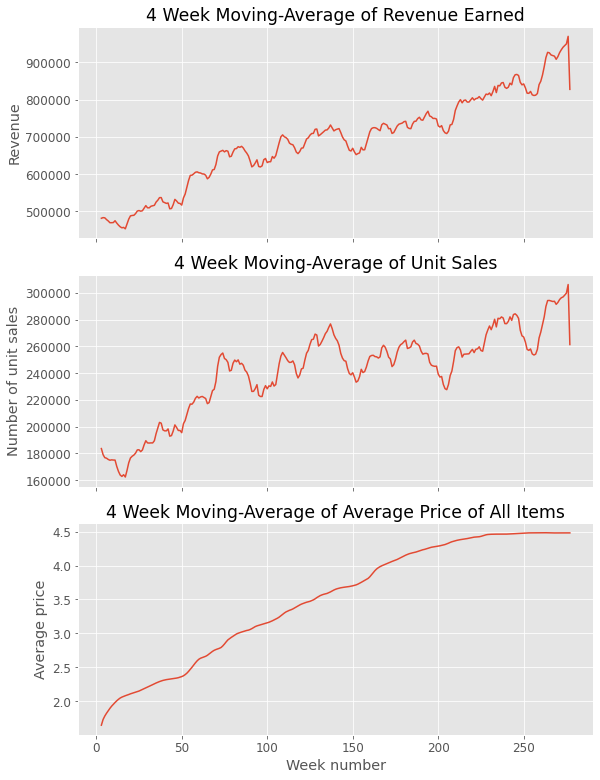

In [12]:
total_rev = np.sum(weekly_revenue, axis=0)
total_sales = np.sum(weekly_sales, axis=0)
avg_prices = np.mean(weekly_prices, axis=0)

window_size = 4
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8.5, 11))
axs[0].plot(np.arange(num_weeks), total_rev.rolling(window_size).mean())
axs[1].plot(np.arange(num_weeks), total_sales.rolling(window_size).mean())
axs[2].plot(np.arange(num_weeks), avg_prices.rolling(window_size).mean())

axs[0].set_title(f"{window_size} Week Moving-Average of Revenue Earned")
axs[1].set_title(f"{window_size} Week Moving-Average of Unit Sales")
axs[2].set_title(f"{window_size} Week Moving-Average of Average Price of All Items")

axs[0].set_ylabel("Revenue")
axs[1].set_ylabel("Number of unit sales")
axs[2].set_ylabel("Average price")

plt.xlabel("Week number")


plt.tight_layout()
plt.show()

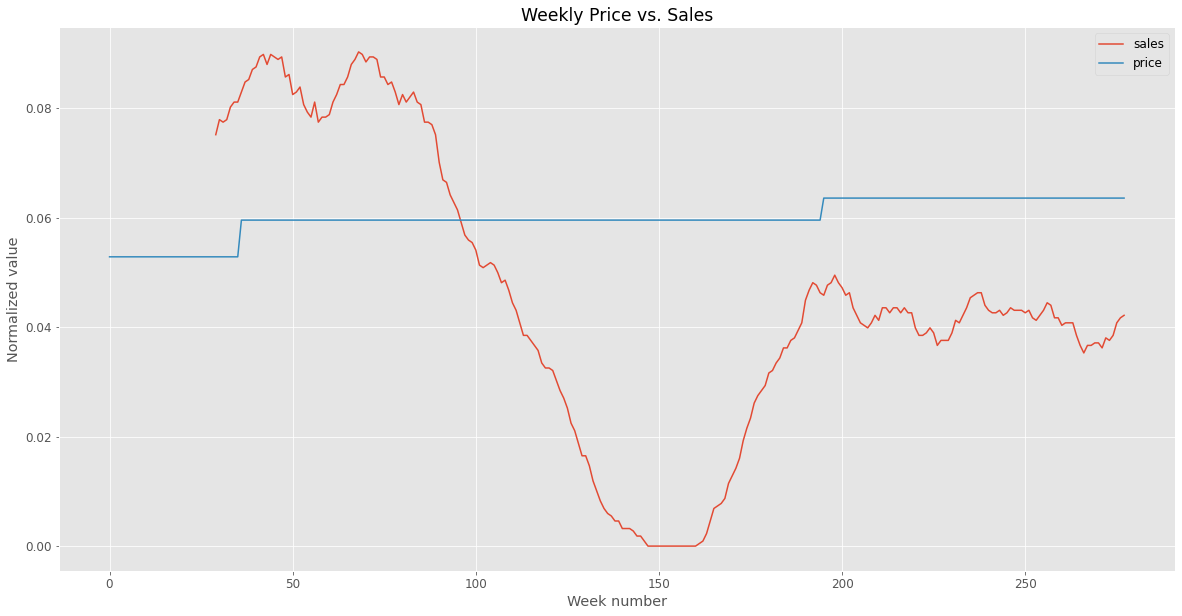

In [13]:
idx = 1

plt.figure(figsize=(20, 10))
plt.plot(np.arange(num_weeks), weekly_sales_scaled.iloc[idx].rolling(30).mean(), label='sales')
plt.plot(np.arange(num_weeks), weekly_prices_scaled.iloc[idx], label='price')
plt.legend()
plt.title(f"Weekly Price vs. Sales")
plt.xlabel("Week number")
plt.ylabel("Normalized value")

plt.show()

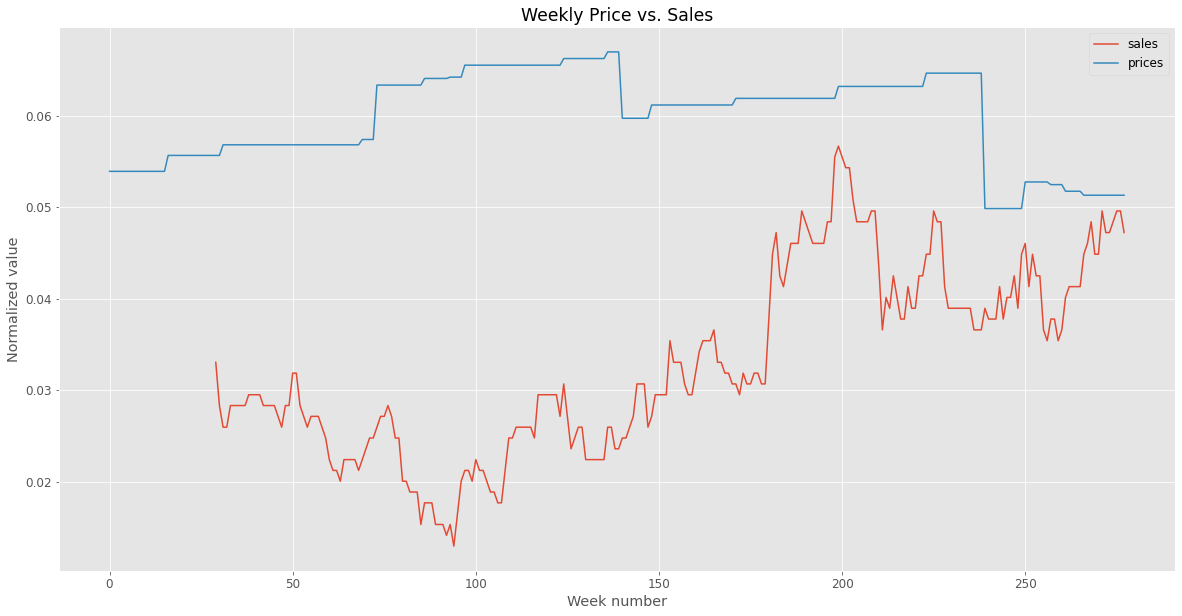

In [14]:
idx = 1
plt.figure(figsize=(20, 10))
plt.plot(np.arange(num_weeks), weekly_sales_scaled[(weekly_sales_scaled.index.get_level_values('item_id') == 'FOODS_1_095') & (weekly_sales_scaled.index.get_level_values('store_id') == 'TX_1')].iloc[0].rolling(30).mean(), label='sales')
plt.plot(np.arange(num_weeks), weekly_prices_scaled[(weekly_prices_scaled.index.get_level_values('item_id') == 'FOODS_1_095') & (weekly_prices_scaled.index.get_level_values('store_id') == 'TX_1')].iloc[0], label='prices')
plt.legend()
plt.title(f"Weekly Price vs. Sales")
plt.xlabel("Week number")
plt.ylabel("Normalized value")

plt.show()

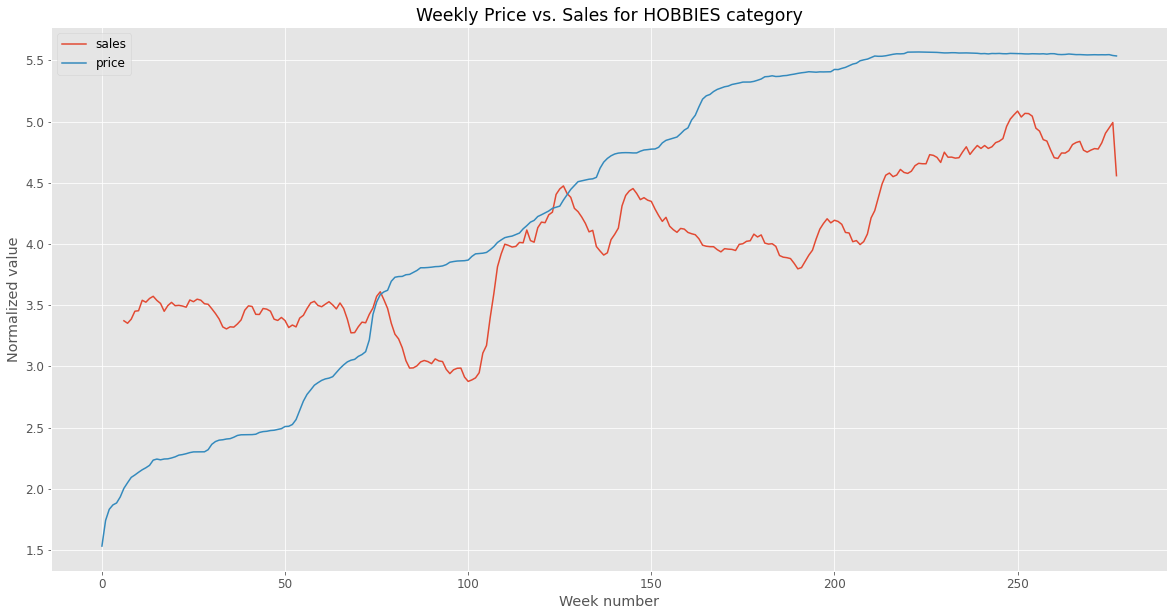

In [15]:
idx = 'HOBBIES'

plt.figure(figsize=(20, 10))
cat_sales = weekly_sales.groupby(['cat_id']).mean()
cat_prices = weekly_prices.groupby(['cat_id']).mean()

plt.plot(np.arange(num_weeks), cat_sales.loc[idx].rolling(7).mean(), 
         label='sales')
plt.plot(np.arange(num_weeks), cat_prices.loc[idx], label='price')
plt.legend()
plt.title(f"Weekly Price vs. Sales for {idx} category")
plt.xlabel("Week number")
plt.ylabel("Normalized value")

plt.show()

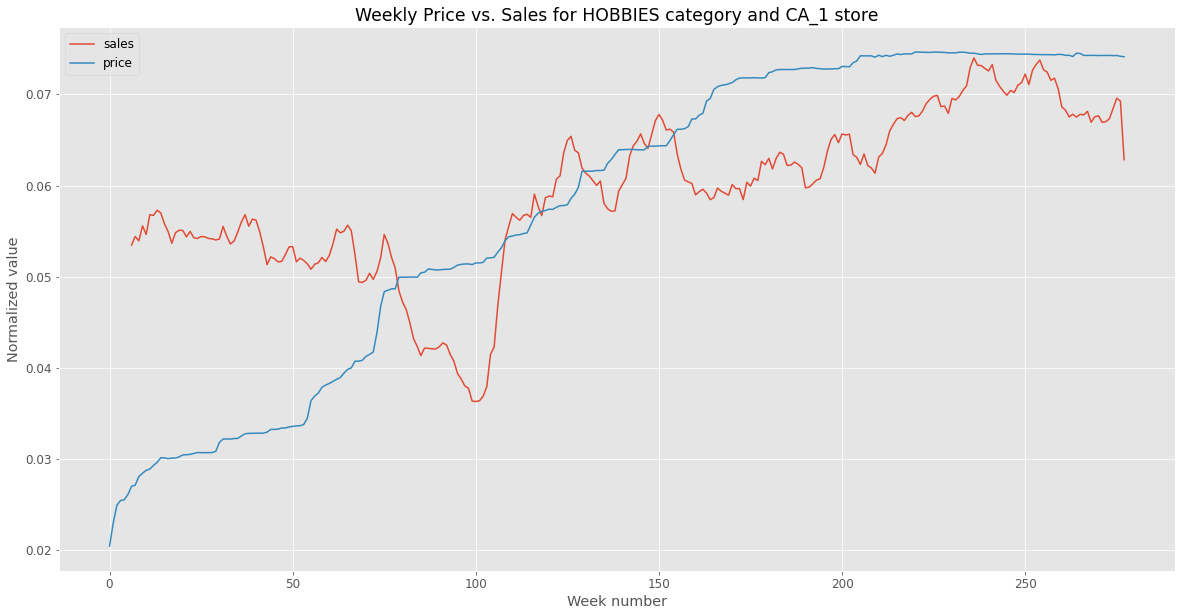

In [16]:
idx = ('HOBBIES', 'CA_1')

plt.figure(figsize=(20, 10))
cat_sales = weekly_sales.groupby(['cat_id', 'store_id']).mean()
cat_prices = weekly_prices.groupby(['cat_id', 'store_id']).mean()
cat_sales = pd.DataFrame(scaler.fit_transform(cat_sales),
                         columns=cat_sales.columns,
                         index=cat_sales.index)
cat_prices = pd.DataFrame(scaler.fit_transform(cat_prices),
                          columns=cat_prices.columns,
                          index=cat_prices.index)
plt.plot(np.arange(num_weeks), cat_sales.loc[idx].rolling(7).mean(), 
         label='sales')
plt.plot(np.arange(num_weeks), cat_prices.loc[idx], label='price')
plt.legend()
plt.title(f"Weekly Price vs. Sales for {idx[0]} category and {idx[1]} store")
plt.xlabel("Week number")
plt.ylabel("Normalized value")

plt.show()

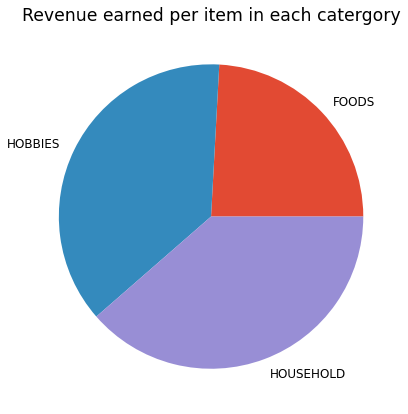

In [17]:
cat_sales = weekly_sales.groupby('cat_id').sum().sum(axis=1)
cat_rev = weekly_revenue.groupby('cat_id').sum().sum(axis=1)
plt.figure(figsize=(7, 7))
plt.pie(cat_rev / cat_sales, labels=cat_sales.index)
plt.title("Revenue earned per item in each catergory")

plt.show()

### Items

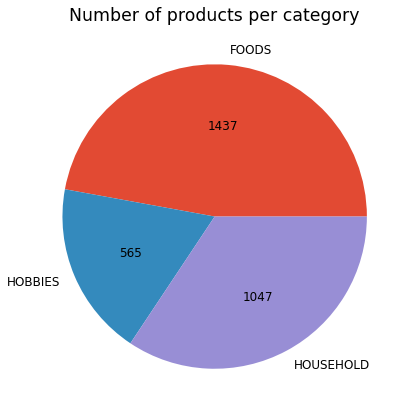

In [18]:
cat_items = sales.groupby('cat_id')['item_id'].nunique()

plt.figure(figsize=(7, 7))
plt.pie(cat_items, labels= cat_items.index, 
        autopct=lambda x: math.ceil(sum(cat_items) * x / 100))
plt.title("Number of products per category")
plt.show()

In [19]:
temp = prices.groupby(['store_id', 'item_id'])['sell_price'].nunique()
print(f"Number of items that had a price change: {len(temp[temp != 1])}/{len(temp)}")

Number of items that had a price change: 22243/30490


### Price Distributions

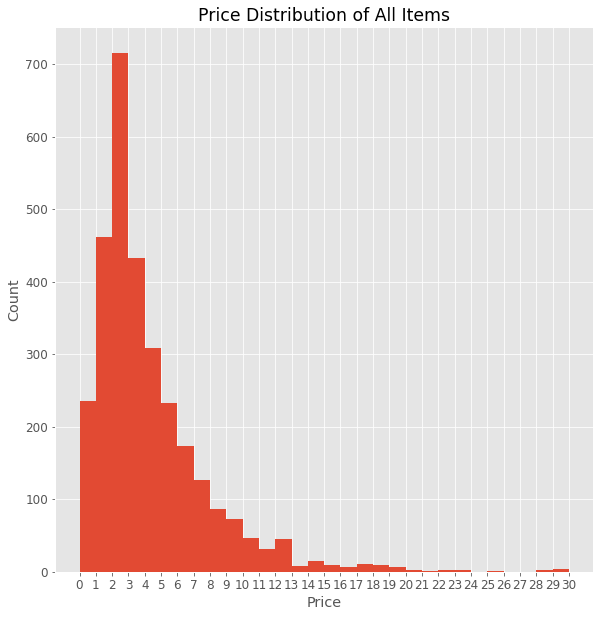

In [20]:
item_prices = prices.groupby('item_id')['sell_price'].mean()

plt.figure(figsize=(8.5, 9))
plt.hist(item_prices, bins=np.arange(math.ceil(max(item_prices)) + 1))
plt.xticks(ticks=np.arange(0, math.ceil(max(item_prices)) + 1))

plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution of All Items")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

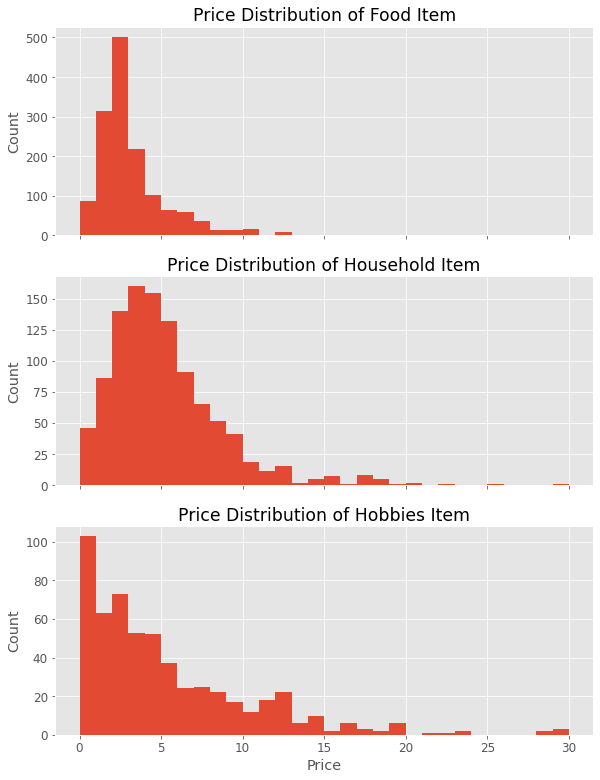

In [21]:
foods_items = prices[prices['item_id'].str.contains('FOODS')]
foods_prices = foods_items.groupby('item_id')['sell_price'].mean()

household_items = prices[prices['item_id'].str.contains('HOUSEHOLD')]
household_prices = household_items.groupby('item_id')['sell_price'].mean()

hobbies_items = prices[prices['item_id'].str.contains('HOBBIES')]
hobbies_prices = hobbies_items.groupby('item_id')['sell_price'].mean()

window_size = 4
_, axs = plt.subplots(3, 1, sharex=True, figsize=(8.5, 11))
axs[0].hist(foods_prices, bins=np.arange(math.ceil(max(foods_prices)) + 1))
axs[1].hist(household_prices, 
            bins=np.arange(math.ceil(max(household_prices)) + 1))
axs[2].hist(hobbies_prices, 
            bins=np.arange(math.ceil(max(hobbies_prices)) + 1))

axs[0].set_title("Price Distribution of Food Item")
axs[1].set_title("Price Distribution of Household Item")
axs[2].set_title("Price Distribution of Hobbies Item")

axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")
axs[2].set_ylabel("Count")
plt.xlabel("Price")


plt.tight_layout()
plt.show()

### Seasonality

In [22]:
daily_sales = np.sum(sales.iloc[:, 6:], axis=0)
sales_cal = calendar[:daily_sales.shape[0]].copy()
sales_cal['sales'] = daily_sales.values
sales_cal

date  wm_yr_wk    weekday  wday  month  year       d event_name_1  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1          NaN   
1     2011-01-30     11101     Sunday     2      1  2011     d_2          NaN   
2     2011-01-31     11101     Monday     3      1  2011     d_3          NaN   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4          NaN   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5          NaN   
...          ...       ...        ...   ...    ...   ...     ...          ...   
1936  2016-05-18     11616  Wednesday     5      5  2016  d_1937          NaN   
1937  2016-05-19     11616   Thursday     6      5  2016  d_1938          NaN   
1938  2016-05-20     11616     Friday     7      5  2016  d_1939          NaN   
1939  2016-05-21     11617   Saturday     1      5  2016  d_1940          NaN   
1940  2016-05-22     11617     Sunday     2      5  2016  d_1941          NaN   

     event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sales  
0             NaN          NaN          NaN        0        0        0  32631  
1             NaN          NaN          NaN        0        0        0  31749  
2             NaN          NaN          NaN        0        0        0  23783  
3             NaN          NaN          NaN        1        1        0  25412  
4             NaN          NaN          NaN        1        0        1  19146  
...           ...          ...          ...      ...      ...      ...    ...  
1936          NaN          NaN          NaN        0        0        0  37096  
1937          NaN          NaN          NaN        0        0        0  36963  
1938          NaN          NaN          NaN        0        0        0  42552  
1939          NaN          NaN          NaN        0        0        0  51518  
1940          NaN          NaN          NaN        0        0        0  54338  

[1941 rows x 15 columns]

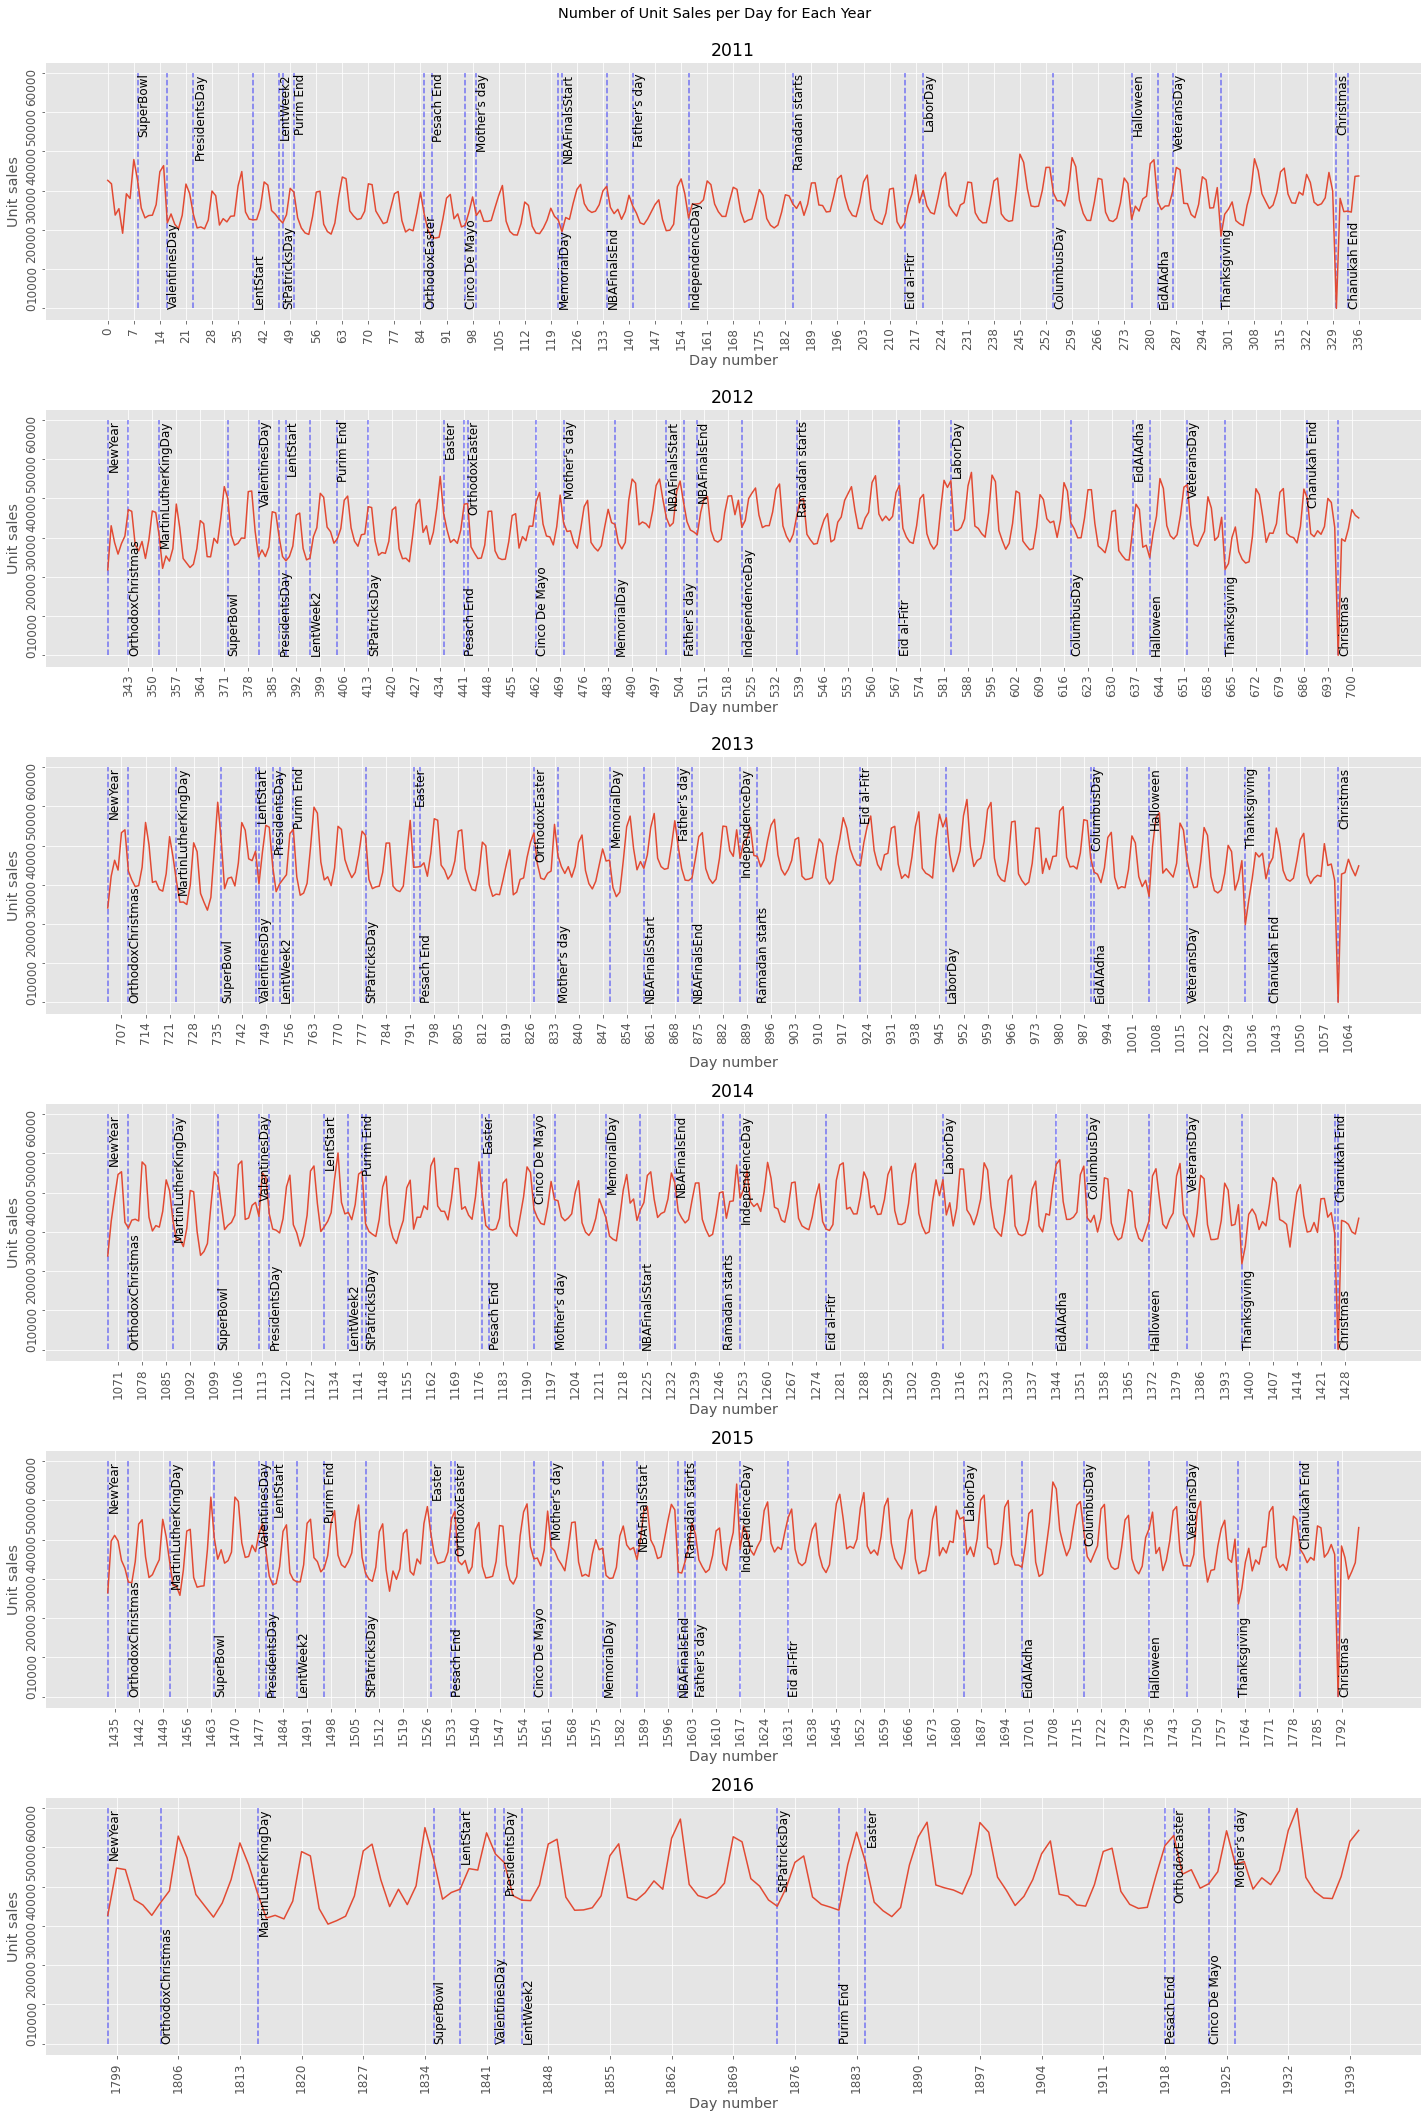

In [23]:
year = 2011
years = sales_cal['year'].unique()
fig, axs = plt.subplots(6, 1, figsize=(20, 30))
axs = axs.flatten()
for i, year in enumerate(years):
    year_sales = sales_cal[sales_cal['year'] == year]
    minv, maxv = min(sales_cal['sales']), max(sales_cal['sales'])
    evnts = year_sales['event_name_1'][~year_sales['event_name_1'].isnull()]
    axs[i].plot(year_sales['sales'])
    axs[i].set_xticks(ticks=year_sales[year_sales['wday'] == 1].index)
    axs[i].set_title(year)
    axs[i].tick_params(labelrotation=90)
    axs[i].vlines(evnts.index, minv, maxv, linestyles='--', color='b', alpha = 0.5)
    for ie, (idx, evnt) in enumerate(evnts.items()):
        text_y = minv if ie % 2 else maxv
        text_align = 'bottom' if ie % 2 else 'top'
        axs[i].text(idx, text_y, evnt, rotation=90, va=text_align)
        axs[i].set_xlabel("Day number")
        axs[i].set_ylabel("Unit sales")

fig.suptitle("Number of Unit Sales per Day for Each Year")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

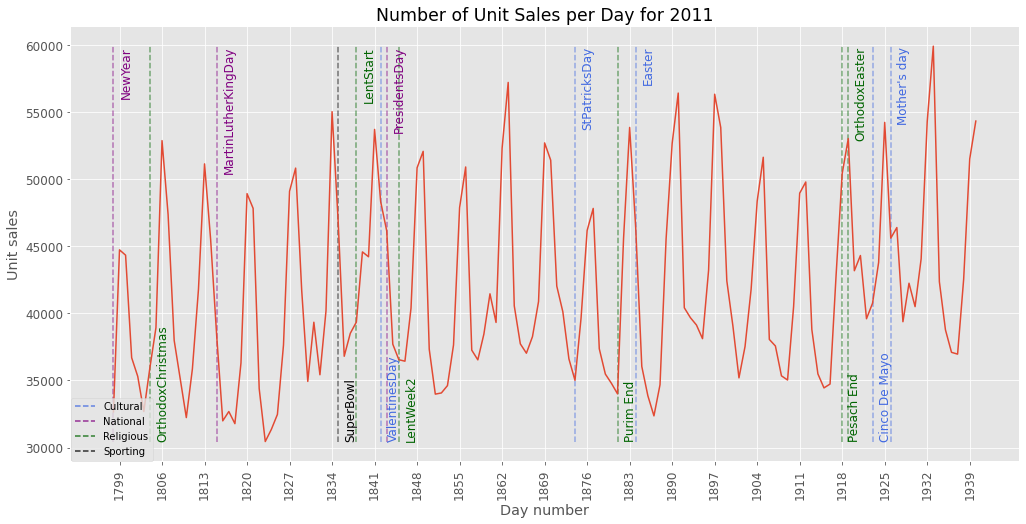

In [24]:
years = sales_cal['year'].unique()
plt.figure(figsize=(17, 8))
year_sales = sales_cal[sales_cal['year'] == year]
minv, maxv = min(year_sales['sales']), max(year_sales['sales'])
evnts = year_sales[~year_sales['event_name_1'].isnull()][['event_name_1', 
                                                          'event_type_1']]
colors = {'Cultural': 'royalblue', 'National': 'purple', 
          'Religious': 'darkgreen', 'Sporting': 'black'}
plt.plot(year_sales['sales'])
plt.xticks(ticks=year_sales[year_sales['wday'] == 1].index, rotation=90)
plt.title(year)
for etype, ecolor in colors.items():
    evnt = evnts[evnts['event_type_1'] == etype]    
    plt.vlines(evnt.index, minv, maxv, linestyles='--', 
                color=ecolor, alpha = 0.5, label=etype)
for ie, (idx, evnt, etype) in enumerate(evnts.itertuples()):
    text_y = minv if ie % 2 else maxv
    text_align = 'bottom' if ie % 2 else 'top'
    plt.text(idx + 1, text_y, evnt, rotation=90, 
             va=text_align, color=colors[etype])
    plt.xlabel("Day number")
    plt.ylabel("Unit sales")

leg = plt.legend(prop={'size': 10}, bbox_to_anchor=(0.092, 0.158))
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
plt.title("Number of Unit Sales per Day for 2011")
plt.show()

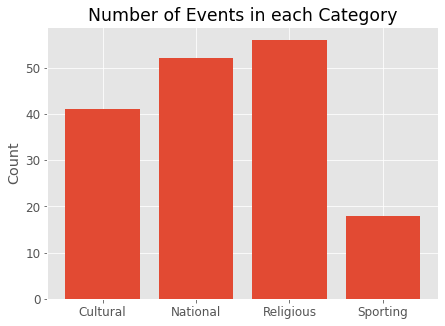

In [25]:
event_types_1 = calendar.groupby('event_type_1')['d'].nunique()
event_types_2 = calendar.groupby('event_type_2')['d'].nunique()
event_types = event_types_1.add(event_types_2, fill_value=0)

plt.figure(figsize=(7, 5))
plt.bar(event_types.index, event_types)
plt.ylabel("Count")
plt.title("Number of Events in each Category")
plt.show()

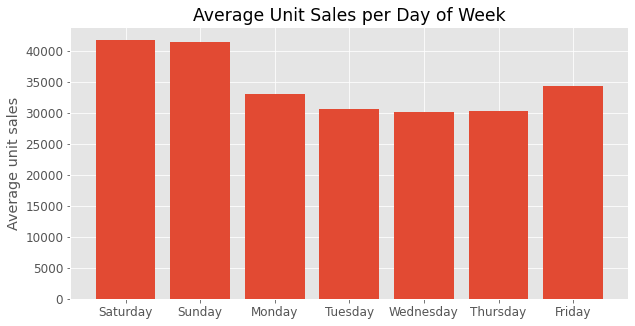

In [26]:
wday_sales = sales_cal.groupby('wday')['sales'].mean()
plt.figure(figsize=(10, 5))
plt.bar(sales_cal[:7]['weekday'], wday_sales)
plt.ylabel("Average unit sales")
plt.title("Average Unit Sales per Day of Week")

plt.show()

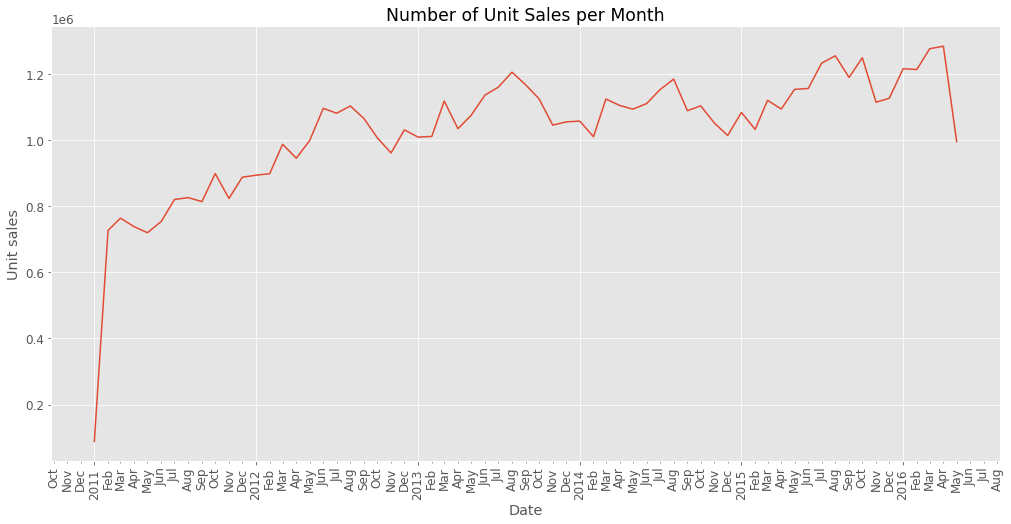

In [27]:
plt.figure(figsize=(17, 8))
monthly_sales = sales_cal.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly_sales['date'] = monthly_sales.apply(lambda x: datetime.datetime(x['year'], x['month'], 1), axis=1)

plt.plot('date', 'sales', data=monthly_sales)
plt.xlabel("Date")
plt.ylabel("Unit sales")
plt.title("Number of Unit Sales per Month")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

plt.show()

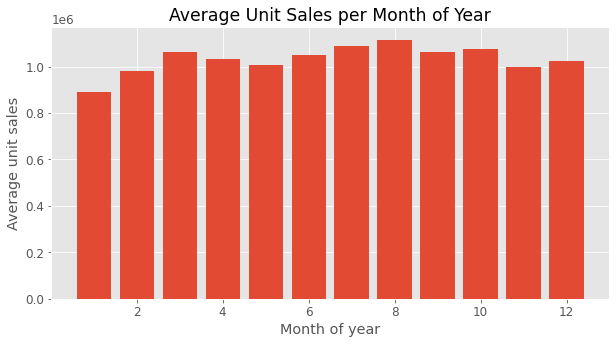

In [28]:
month_sales = monthly_sales.groupby('month')['sales'].mean()
plt.figure(figsize=(10, 5))
plt.bar(month_sales.index, month_sales)
plt.ylabel("Average unit sales")
plt.xlabel("Month of year")

plt.title("Average Unit Sales per Month of Year")

plt.show()

### Sales

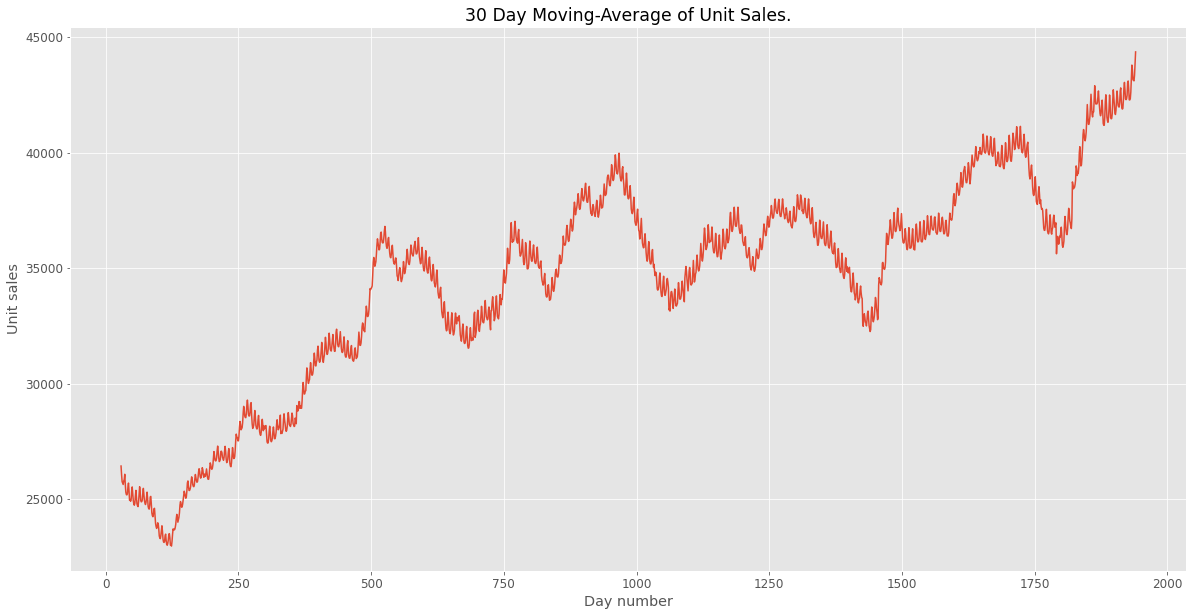

In [29]:
total_sales = np.sum(sales.iloc[:, 6:], axis=0)
plt.figure(figsize=(20, 10))
window_size = 30
plt.plot(np.arange(len(total_sales)), total_sales.rolling(window_size).mean())
plt.title(f"{window_size} Day Moving-Average of Unit Sales.")
plt.xlabel("Day number")
plt.ylabel("Unit sales")
plt.show()

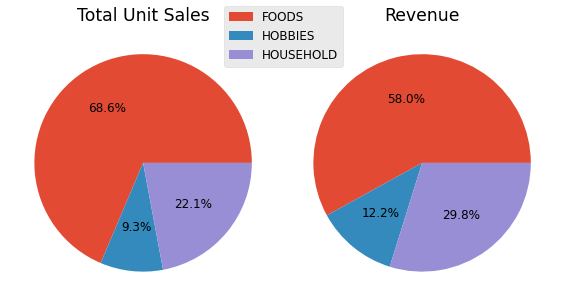

In [30]:
cat_sales = sales.groupby('cat_id').sum().sum(axis=1)
cat_rev = weekly_revenue.groupby('cat_id').sum().sum(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(cat_sales, autopct='%1.1f%%')
axs[0].set_title("Total Unit Sales")
axs[1].pie(cat_rev, autopct='%1.1f%%')
axs[1].set_title("Revenue")
fig.legend(cat_rev.index, bbox_to_anchor=(0.485, 0.85))
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

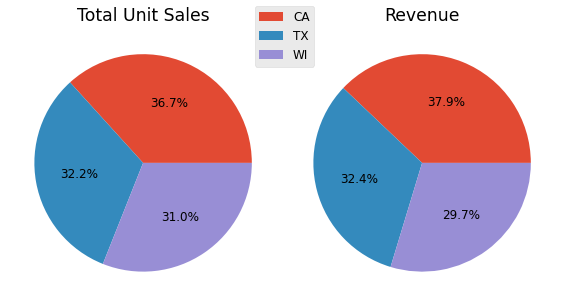

In [31]:
state_sales = sales.groupby('state_id').sum().sum(axis=1)
state_rev = weekly_revenue.groupby('state_id').sum().sum(axis=1)
num_stores = sales.groupby('state_id')['store_id'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(state_sales / num_stores, autopct='%1.1f%%',)
axs[0].set_title("Total Unit Sales")
axs[1].pie(state_rev / num_stores, autopct='%1.1f%%',)
axs[1].set_title("Revenue")
fig.legend(state_rev.index, bbox_to_anchor=(0.445, 0.85))
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

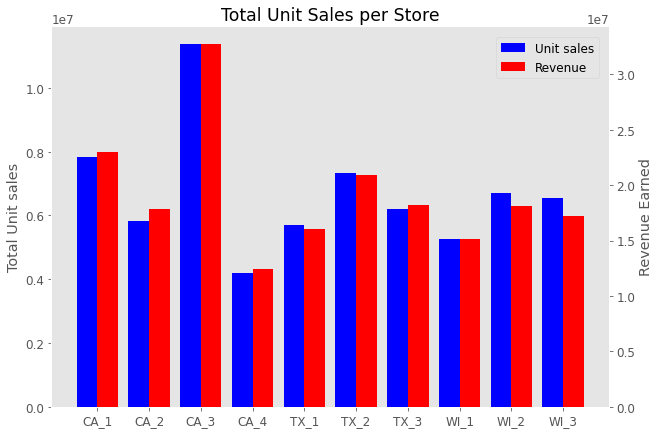

In [32]:
store_sales = sales.groupby('store_id').sum().sum(axis=1)
store_rev = weekly_revenue.groupby('store_id').sum().sum(axis=1)

fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()
ax1.bar(np.arange(len(store_sales)) - 0.2, store_sales, width=0.4, color='b', label='Unit sales')
ax2.bar(np.arange(len(store_sales)) + 0.2, store_rev, width=0.4, color='r', label='Revenue')

plt.title("Total Unit Sales per Store")
ax1.set_ylabel("Total Unit sales")
ax2.set_ylabel("Revenue Earned")
plt.xticks(ticks=np.arange(len(store_sales)), labels=store_sales.index)

ax1.grid(False)
ax2.grid(False)
fig.legend(bbox_to_anchor=(0.84, 0.8))
plt.show()

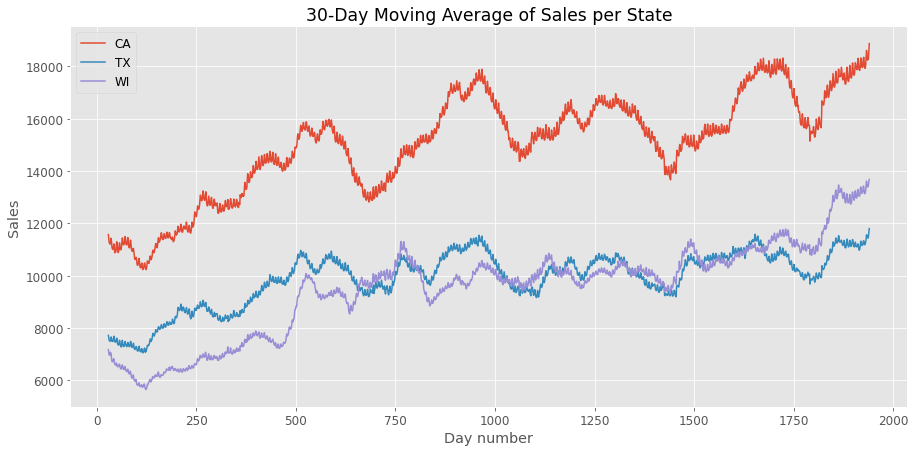

In [33]:
# Sales per state
plt.figure(figsize=(15, 7))
states = sales['state_id'].unique()
for state in states:
    state_sales = sales[sales['state_id'] == state].iloc[:, 6:].sum(axis=0).rolling(30).mean().values
    plt.plot(state_sales, label=state)

plt.xlabel('Day number')
plt.ylabel('Sales')
plt.title('30-Day Moving Average of Sales per State')
plt.legend()
plt.show()

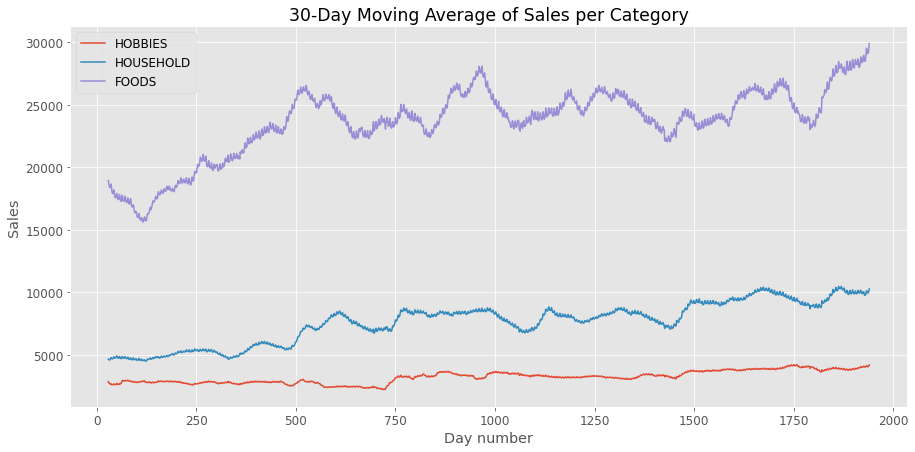

In [34]:
# Sales per catergory
plt.figure(figsize=(15, 7))
cats = sales['cat_id'].unique()
for cat in cats:
    cat_sales = sales[sales['cat_id'] == cat].iloc[:, 6:].sum(axis=0).rolling(30).mean().values
    plt.plot(cat_sales, label=cat)

plt.xlabel('Day number')
plt.ylabel('Sales')
plt.title('30-Day Moving Average of Sales per Category')
plt.legend()
plt.show()

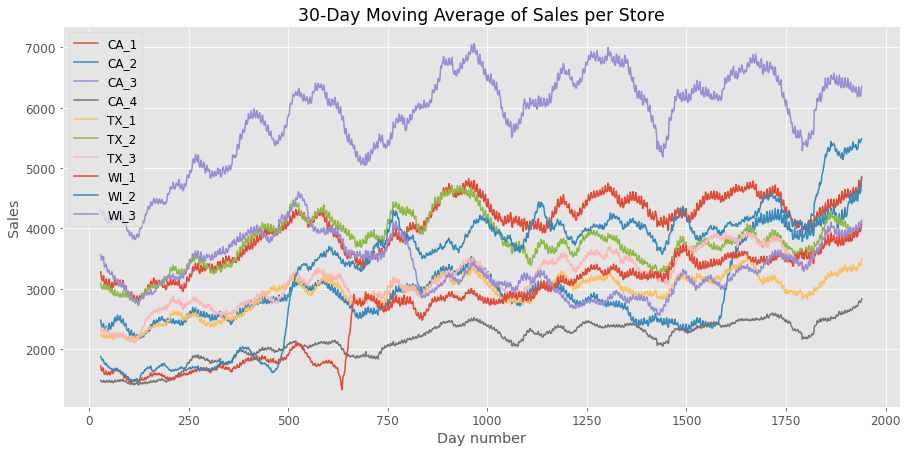

In [35]:
# Sales per store
plt.figure(figsize=(15, 7))
stores = sales['store_id'].unique()
for store in stores:
    store_sales = sales[sales['store_id'] == store].iloc[:, 6:].sum(axis=0).rolling(30).mean().values
    plt.plot(store_sales, label=store)

plt.xlabel('Day number')
plt.ylabel('Sales')
plt.title('30-Day Moving Average of Sales per Store')
plt.legend()
plt.show()

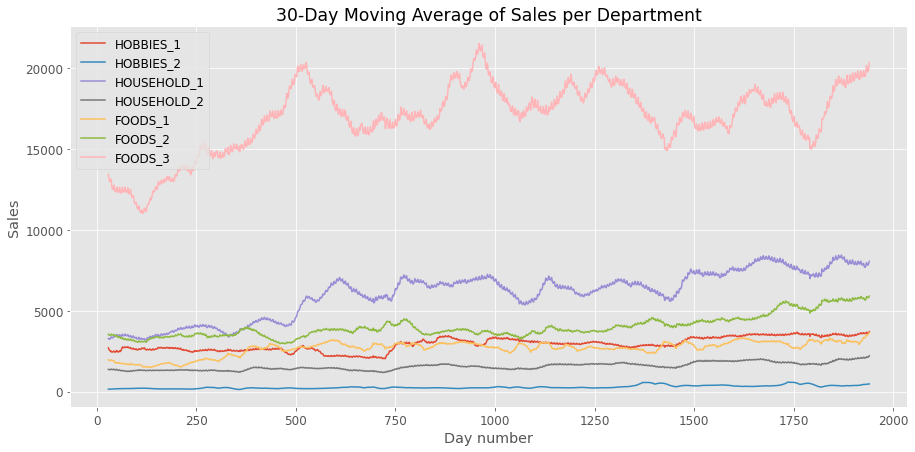

In [36]:
# Sales per department
plt.figure(figsize=(15, 7))
depts = sales['dept_id'].unique()
for dept in depts:
    dept_sales = sales[sales['dept_id'] == dept].iloc[:, 6:].sum(axis=0).rolling(30).mean().values
    plt.plot(dept_sales, label=dept)

plt.xlabel('Day number')
plt.ylabel('Sales')
plt.title('30-Day Moving Average of Sales per Department')
plt.legend()
plt.show()

## Models

### Helper functions

In [3]:
# Helper functions:

def mean_error(y_true, y_pred):
    """
    Calculates the mean difference between y_true and y_pred.
    
    :param y_true: The target values.
    :param y_pred: The prediction values.

    :return The mean error between y_true and y_pred.
    """
    return np.mean(y_pred - y_true)

def rmse_tf(y_true, y_pred):
    """
    A custom keras loss function for calculating the root mean square error between y_true and 
        y_pred.
    
    :param y_true: The target values.
    :param y_pred: The prediction values.

    :return The root mean square error between y_true and y_pred.
    """
    return kb.sqrt(kb.mean(kb.square(y_pred - y_true)))

def rmse(y_true, y_pred):
    """
    Calculates the root mean square error between y_true and y_pred.
    
    :param y_true: The target values.
    :param y_pred: The prediction values.

    :return The root mean square error between y_true and y_pred.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsse(y_true, y_pred, naive_true=None, naive_pred=None):
    """
    Calculates the root mean square scaled error for predictions y_pred and targets y_true compared
        to a naive model
    
    :param y_true: The target values of the model to be evaluated.
    :param y_pred: The prediction values the model to be evaluated.
    :param naive_true: The target values of the naive model.
    :param naive_pred: The prediction values the naive model.

    :return The root mean square scaled error of the predictions compared to the predictions of a 
        naive model.
    """
    mse = mean_squared_error(y_true, y_pred)

    if naive_true is None or naive_pred is None:
        naive_true = y_true[1:]
        naive_pred = y_true[:-1]
    naive_mse = mean_squared_error(naive_true, naive_pred)

    return np.sqrt(mse / naive_mse)

def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.

    :param df: The dataframe to reduce the memory of.

    Reference: https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff     
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Reducing memory usage - Current Memory usage is {:.2f}' 
                     'MB...').format(start_mem), flush=True)
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f}MB'.format(end_mem), flush=True)
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem), flush=True)
    
    return df

def plot_loss(trn_loss, val_loss):
    """
    Plots the loss vs. epoch of a model given the training and validation losses per epoch.
    
    :param trn_loss: A list training losses per epoch.
    :param val_loss: A list validation losses per epoch.
    """
    ticks = np.arange(0, len(trn_loss) + 1, len(trn_loss) // 10)
    plt.figure(figsize=(15, 5))
    plt.plot(trn_loss)
    plt.plot(val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.xticks(ticks=ticks, labels=ticks)
    plt.legend(['Training', 'Validation'])

    plt.show()
    
def lstm_dataprep(data, 
                  start_day=300, 
                  val_days=28, 
                  tst_days=28, 
                  steps=28, 
                  scaler=None, 
                  verbose=True, 
                  add_features=True,
                  save=False, 
                  load=False, 
                  filename='lstm_data.h5'):
    """
    Preprocesses the data for the LSTM model.
    
    :param data: A pandas dataframe containing the data.
    :param start_day: The number of days to drop from the beginning of the data. This is meant to be used to avoid too 
        many zeros in the begnning of the timeseries.
    :param val_days: The number of days to use for the validation set.
    :param tst_days: The number of days to use for the test set.
    :param steps: The number of steps to use for the LSTM data.
    :param scaler: A scaler to use to scale the data. If None, no scaling is done.
    :param verbose: Whether to print the progress.
    :param add_features: Whether to add features other than item sales.
    :param save: Whether to save the preprocessed data to file. This parameter is overwritten by load.
    :param load: Whether to load a previously preprocessed data from file. This parameter takes priority over save.
    :param filename: The file name for saving or loading the preprocessed data.

    :return A dictionary containing the preprocessed training, validation, and test sets.
    """
    items = data['id'].values
    n_items = len(items)  

    if not load:
        data = data.iloc[:, 6 + start_day:].transpose()
        data.columns = items

        if add_features:
            # Adding events to the feature set.
            if verbose:
                print("Adding calender features...")
            calndr = calendar[['d', 'event_name_1', 'wday', 'month', 'year']]
            calndr['event_name_1'] = calndr['event_name_1'].shift(-1).fillna(0)
            calndr['event_name_1'][calndr['event_name_1'] != 0] = 1
            calndr['event_tomo_1'] = calndr['event_name_1'].shift(-1)
            calndr['day'] = calndr['d'].apply(lambda x: int(x[2:]))
            calndr.set_index('d', inplace=True)
            data = data.join(calndr)

            # Adding Snaps to the feature set.
            if verbose:
                print("Adding snaps to the feature set...")
            snaps = calendar[['d', 'snap_CA', 'snap_TX', 'snap_WI']]
            snaps.set_index('d', inplace=True)
            data = data.join(snaps)

        if verbose:
            print('Added features:', list(data.columns[n_items:]))
        if save:
            if verbose:
                print('\nSaving preprocessed data to file...', flush=True)
            data.to_hdf(data_dir + filename, 'lstm_data')
    else:
        if verbose:
            print('Loading preprocessed data from file... ', flush=True)
        data = pd.read_hdf(data_dir + filename)

    if verbose:
        print("Separating training, validation, and test sets...")
    trn, val, tst = lstm_trn_val_tst_split(data.values, steps, val_days, tst_days)

    if scaler is not None:
        if verbose:
            print("Scaling the data...")
        trn = scaler.fit_transform(trn)
        if val_days: val = scaler.transform(val)
        if tst_days: tst = scaler.transform(tst)

    trn = trn.astype(float)
    val = val.astype(float)
    tst = tst.astype(float)

    if verbose:
        print("Generating time series data...")
    xtrn, ytrn = lstm_generate_timeseries(trn, steps, n_items, verbose=verbose)
    xval, yval = lstm_generate_timeseries(val, steps, n_items, verbose=verbose)
    xtst, ytst = lstm_generate_timeseries(tst, steps, n_items, verbose=verbose)

    return {'trn': {'trn': trn, 'x': xtrn, 'y': ytrn}, 
            'val': {'val': val, 'x': xval, 'y': yval}, 
            'tst': {'tst': tst, 'x': xtst, 'y': ytst}}

def lstm_generate_timeseries(data, steps, n_out, verbose=1):
    """
    Generates timeseries data to be used by the LSTM model.
    
    :param data: The data to generate LSTM timeseries data from.
    :param steps: The number of steps to use for each timeseries.
    :param n_out: The number of LSTM predictions.
    :param verbose: Whether to show the progress.

    :return The LSTM timeseries input and their targets.
    """
    x_trn, y_trn = [], []
    iterator = range(steps, data.shape[0])
    for i in (tqdm(iterator) if verbose else iterator):
        x_trn.append(data[i - steps: i])
        y_trn.append(data[i][:n_out])

    x_trn = np.array(x_trn, ndmin=3)
    y_trn = np.array(y_trn, ndmin=2)

    return x_trn, y_trn

def lstm_trn_val_tst_split(data, steps, val_days, tst_days):
    """
    Separates the data into training, validation, and test sets for the LSTM model.
    
    :param data: The data to use.
    :param steps: The number of steps for the LSTM model.
    :param val_days: The number of days to use for the validation set.
    :param tst_days: The number of days to use for the test set.

    :return The LSTM timeseries input and their targets.
    """
    trn, val, tst = np.array([]), np.array([]), np.array([])
    if tst_days:
        tst = data[-tst_days-steps:].copy()
    if tst_days and val_days:
        val = data[-tst_days-val_days-steps: -tst_days].copy()
    elif val_days:
        val = data[-tst_days-val_days-steps:].copy()
    
    if tst_days or val_days:
        trn = data[:-tst_days-val_days].copy()
    else:
        trn = data.copy()
    return trn, val, tst

def row_wise_dataprep(data, lags=None , window_sizes=None, start_day=300, days_pred=28,
                      save=False, load=False, filename = 'rw_data.h5', verbose=True):
    """
    Preprocesses the data for the MLP and LGBM models.
    
    :param data: The data to use.
    :param lags: A list of lag values to use for creating sale lag features.
    :param window_sizes: A list of window sizes to use for creating rolling sales mean and sales std features.
    :param start_day: The number of days to drop from the beginning of the data. This is meant to be used to avoid too 
        many zeros in the begnning of the timeseries.
    :param days_pred: The number of steps the model will be predicting. This will shift all lags and rolling mean/std
        features by days_pred. This is to avoid the error of the model to propagate through later predictions.
    :param save: Whether to save the preprocessed data to file. This parameter is overwritten by load.
    :param load: Whether to load a previously preprocessed data from file. This parameter takes priority over save.
    :param filename: The file name for saving or loading the preprocessed data.
    :param verbose: Whether to print the progress.

    :return The preprocessed data.
    """
    if not load:
        if verbose:
            print('Merging datasets...', flush=True)
        data = data.drop(columns=[f'd_{i}' for i in range(1, start_day + 1)])\
                   .melt(id_vars=data.columns[:6], 
                         var_name='d', 
                         value_name='sales')\
                   .merge(calendar.drop(columns=['date', 'weekday', 'event_type_1', 'event_name_2', 'event_type_2']),
                          on='d',
                          how='inner',
                          copy=False)\
                   .merge(prices, 
                          on=['store_id', 'item_id', 'wm_yr_wk'],
                          how='inner',
                          copy=False).drop(columns=['wm_yr_wk'])

        if lags is not None:
        # Introduce lag features.
            if verbose:
                print('Creating lag features...', flush=True)
            for lag in tqdm(lags):
                data[f'lag_{lag}'] = data[['id', 'sales']].groupby('id')['sales']\
                                                        .shift(lag + days_pred)

        if window_sizes is not None:
        # Introduce rolling mean and std features.
            if verbose:
                print('Creating rolling mean and std features...', flush=True, end='')
            g = data[['id', 'sales']].groupby('id')['sales'].shift(days_pred)
            for win_size in tqdm(window_sizes):
                w = g.rolling(win_size)
                rmean = w.mean()
                rstd = w.std()
                data[f'rmean_{win_size}'] = rmean
                data[f'rstd_{win_size}'] = rstd                                        

        if verbose:
            print('Adding calendar data...', flush=True)
        data['event_name_1'] = data['event_name_1'].fillna('')
        events_tomo = calendar[['d', 'event_name_1']]
        events_tomo['events_tomo'] = events_tomo['event_name_1'].fillna('').shift(-1)
        data = data.merge(events_tomo.drop(columns=['event_name_1']), 
                          on='d', 
                          how='inner', 
                          copy=False)
        data['d'] = data['d'].apply(lambda x: int(x[2:]))

        # Encode categorical variables.
        if verbose:
            print('Encoding the categorical features...', flush=True)
        label_encoder = LabelEncoder()
        encode_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1']
        data[encode_cols] = data[encode_cols].\
                            progress_apply(label_encoder.fit_transform, axis=0)
        data['events_tomo'] = label_encoder.transform(data['events_tomo'])


        # Drop rows with missing values and reduce the memory usage of data.
        data.dropna(inplace=True)
        data = reduce_mem_usage(data)

        if save:
            if verbose:
                print('\nSaving preprocessed data to file...', flush=True)
            data.to_hdf(data_dir + filename, 'rw_data', format='table')        
    else:
        if verbose:
            print('Loading preprocessed data from file... ', flush=True)
        data = pd.read_hdf(data_dir + filename)

    return data

def row_wise_train_test_split(data, val_days=28, tst_days=28, verbose=1):
    """
    Separates the data into training, validation, and test sets for the MLP and LGBM models.
    
    :param data: The data to use.
    :param val_days: The number of days to use for the validation set.
    :param tst_days: The number of days to use for the test set.
    :param verbose: Whether to print the progress.

    :return The training, validation, and test sets.
    """
    # Separate train, validation, and test sets.
    if verbose:
        print('Separating train, validation, and test sets...')
    x = data.drop(columns=['sales', 'id'])
    y = data['sales']

    max_day = x['d'].max()
    xtst = x[x['d'] > max_day-tst_days]
    xval = x[(x['d'] > max_day-tst_days-val_days) & (x['d'] <= max_day-tst_days)]
    xtrn = x[x['d'] <= max_day-tst_days-val_days]

    ytst = y.loc[xtst.index]
    yval = y.loc[xval.index]
    ytrn = y.loc[xtrn.index]

    return {'trn': {'x': xtrn, 'y': ytrn}, 
            'val': {'x': xval, 'y': yval}, 
            'tst': {'x': xtst, 'y': ytst}}

def prepare_lgbm_training_datasets(trn, val=None):
    """
    Prepares datasets to be used by the LGBM model.
    
    :param trn: The training data.
    :param val: The validation data.

    :return LGBM datasets of the given training and validation data.
    """
    cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'wday', 'month', 
                    'event_name_1', 'events_tomo', 'snap_CA', 'snap_TX', 'snap_WI']
    datasets = {}
    datasets['trn'] = lgb.Dataset(trn['x'], label=trn['y'],
                                  categorical_feature=cat_features, 
                                  free_raw_data=False)
    if val is not None:
        datasets['val'] = lgb.Dataset(val['x'], label=val['y'],
                                      categorical_feature=cat_features,
                                      free_raw_data=False)

    return datasets

class PredictionsPlot(keras.callbacks.Callback):
    """
    A keras callback for plotting the predictions of a given model on a given dataset vs. the target values 
        during training. This is meant to visualize the progression in the learning of a model.
    """
    def __init__(self, estimator, x, y, length, idx, period=1):
        """
        Initiates an instance of PredictionsPlot.

        :param estimator: The keras model.
        :param x: The input data for the model.
        :param x: The target data.
        :param length: The length of the plot.
        :param idx: The index of the middle point of the plot within the samples.
        :param period: The number of epochs that should pass before plotting.
        """
        super().__init__()
        self.model = estimator
        self.x = x.copy()
        self.y = y.copy()
        self.period = period
        self.length = length
        self.idx = idx[1]
        self.end = min(idx[0] + self.length // 2, y.shape[0]) 
        self.start = self.end - self.length
        if self.start < 0:
            self.start = 0
            self.end = self.length

    def on_epoch_end(self, epoch, logs={}):
        """
        Plots the iteration after the epoch is done.
        """
        if (epoch + 1) % self.period == 0:
            plt.figure(figsize=(10, 4))
            preds = self.model.predict(self.x, batch_size=28)
            plt.plot(self.y[self.start: self.end, self.idx], 
                     alpha=1, label='Targets', c='b')
            plt.plot(preds[self.start: self.end, self.idx], 
                     alpha=0.7, label='Predictions', c='r')
            plt.xticks(ticks=np.arange(0, self.length + 1, 7))

            plt.legend()
            plt.show()

### LSTM

In [4]:
# Whether to retrain the model or load a previously saved model.
reoptimize_lstm = 0
retrain_lstm = 0
model_dir = proj_dir + 'models/lstm/'
cp_dir = model_dir + 'lstm_best.h5'
log_dir = model_dir + 'lstm_log.csv'
opt_dir = model_dir + 'lstm_optimizer.json'

#### Model Creation

In [5]:
def create_lstm(in_shape,
                out_shape,
                n_layers=1,
                last_units=64,
                units_decay=1,
                hidden_sizes=None,
                learning_rate=0.001, 
                lr_decay=0.0,
                dropout_rate=0.1,
                norm=True):
    """
    Creates an LSTM model.
    
    :param in_shape: The shape of the input data.
    :param out_shape: The shape of the model output.
    :param n_layers: The number of hidden LSTM layers.
    :param last_units: The number of units for the last hidden LSTM layer.
    :param units_decay: The decay rate of the number of units going from last hidden layer to the first.
    :param hidden_sizes: A list containing the number of nodes for each hidden LSTM layer. This is meant to be used as 
        an alternative to n_layers, n_units, and units_scale to specify the number of hidden layers and the number of 
        nodes per hidden layer.
    :param learning_rate: The learning rate of the model.
    :param lr_decay: The learning rate decay of the model.
    :param dropout_rate: The dropout rate for the dropout layers.
    :param norm: Whether to use a batch normalization layer after each LSTM layer or not.
    
    :return An LSTM model.
    """
    kb.clear_session()
    tf.compat.v1.reset_default_graph()
    keras.backend.clear_session()

    n_layers = int(n_layers)
    last_units = int(last_units)
    norm = round(norm)
    model = Sequential()

    if hidden_sizes is not None:
        for i_layer, i_units in enumerate(hidden_sizes):
            return_sequences = False if i_layer+1 == len(hidden_sizes) else True
            if i_layer == 0:  # Specify the input shape for the first layer.
                model.add(LSTM(units=int(i_units), 
                               return_sequences=return_sequences,
                               input_shape=in_shape))
            else:
                model.add(LSTM(units=int(i_units), 
                               return_sequences=return_sequences))  
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate))
    else:
        for i_layer in range(n_layers):
            return_sequences = False if i_layer+1 == n_layers else True
            if i_layer == 0:  # Specify the input shape for the first layer.
                model.add(LSTM(units=max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                               return_sequences=return_sequences,
                               input_shape=in_shape))
            else:
                model.add(LSTM(units=max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                               return_sequences=return_sequences))    
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate))

    # Adding the output layer.
    model.add(Dense(units=out_shape))

    model.compile(optimizer=optimizers.Adam(lr=learning_rate, decay=lr_decay), 
                  loss=rmse_tf)
    
    return model

def score_lstm(data, **model_params):
    """
    Trains an LSTM model on the given data and returns its score.
    
    :param data: The data to create training and validation data from.
    :param model_params: The parameters of the LSTM model.

    :return The score of the LSTM model on the given dataset.
    """
    # Create the data...
    scaler = MinMaxScaler(feature_range=(0, 1))
    steps = int(model_params.pop('steps'))
    batch_size = int(model_params.pop('batch_size'))
    trn, val, _ = lstm_dataprep(data=data,
                                start_day=300, 
                                val_days=28, 
                                tst_days=28, 
                                steps=steps,
                                scaler=scaler,
                                verbose=0).values()    

    # Create the model and early stopping callback.                            
    callback_es = EarlyStopping(monitor='val_loss', patience=10, 
                                mode='min', verbose=2)
    model = create_lstm(in_shape=trn['x'].shape[1:],
                        out_shape=trn['y'].shape[1],
                        **model_params)
    
    # Training...
    log = model.fit(trn['x'], trn['y'],
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(val['x'], val['y']),
                    callbacks=[callback_es],
                    shuffle=True,
                    verbose=0)
    
    # Get the model's best score.
    score = min(log.history['val_loss'])
    del trn, val, model
    gc.collect()
    
    return -score

#### Hyperparameter Optimization

In [6]:
if reoptimize_lstm:
    cont_opt = True  # Whether to continue optimization or not.

    # Defining hyperparameters ranges for optimization.
    n_layers = (3, 5.99)
    last_units = (128, 512)
    units_decay = (0.2, 1)
    learning_rate = (1e-4, 1e-2)
    lr_decay = (0, 1e-3)
    dropout_rate = (0, 0.3)
    norm = (0, 1)
    batch_size = (32, 128)
    steps = (14, 56)

    param_bounds = dict(n_layers=n_layers,
                        last_units=last_units,
                        units_decay=units_decay,
                        learning_rate=learning_rate, 
                        lr_decay=lr_decay,
                        dropout_rate=dropout_rate,
                        norm=norm,
                        batch_size=batch_size,
                        steps=steps)

    # Defining the Bayesian Optimizer.
    scorer = partial(score_lstm, sales)
    transformer = SequentialDomainReductionTransformer(gamma_osc=0.6, eta=0.95)
    optimizer = BayesianOptimization(f=scorer,
                                     pbounds=param_bounds,
                                     verbose=2,
                                     bounds_transformer=transformer)
    if cont_opt:
        load_logs(optimizer, logs=[opt_dir])

    # Save the logs for the optimization progress.
    scr_logger = ScreenLogger()
    f_logger = JSONLogger(path=opt_dir, reset=False if cont_opt else True)
    optimizer.subscribe(Events.OPTIMIZATION_START, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_END, scr_logger)    
    optimizer.subscribe(Events.OPTIMIZATION_STEP, f_logger)

    if not cont_opt:
        # Helping the model by providing it with some hyperparameters 
        # obatined by manual training that work somewhat well.  
        optimizer.probe(lazy=True,
                        params={'n_layers': 3, 
                                'last_units': 256,
                                'units_decay': 0.5,
                                'learning_rate': 0.001,
                                'lr_decay': 0,
                                'dropout_rate': 0.2,
                                'norm': 0,
                                'batch_size': 32,
                                'steps': 14})
        optimizer.probe(lazy=True,
                        params={'n_layers': 3, 
                                'last_units': 400,
                                'units_decay': 0.35,
                                'learning_rate': 0.001,
                                'lr_decay': 0,
                                'dropout_rate': 0.2,
                                'norm': 0,
                                'batch_size': 32,
                                'steps': 42})
    
    # Run the optimization...
    optimizer.maximize(init_points=25, n_iter=200, alpha=1e-6, kappa=2.5)

else:
    # Retrieve optimization progress from file.
    errors, params = [], []
    with open(opt_dir, 'r') as f:
        opt_hist = f.readlines()
    for line in opt_hist:
        print(line, end='')
        hist = json.loads(line)
        errors.append(hist['target'])
        params.append(hist['params']) 

{"target": -0.14079321920871735, "params": {"batch_size": 32.0, "dropout_rate": 0.2, "last_units": 256.0, "learning_rate": 0.001, "lr_decay": 0.0, "n_layers": 3.0, "norm": 0.0, "steps": 14.0, "units_decay": 0.5}, "datetime": {"datetime": "2020-08-08 19:44:35", "elapsed": 0.0, "delta": 0.0}}
{"target": -0.14187900722026825, "params": {"batch_size": 32.0, "dropout_rate": 0.2, "last_units": 400.0, "learning_rate": 0.001, "lr_decay": 0.0, "n_layers": 3.0, "norm": 0.0, "steps": 42.0, "units_decay": 0.35}, "datetime": {"datetime": "2020-08-08 19:55:29", "elapsed": 654.010608, "delta": 654.010608}}
{"target": -0.144876167178154, "params": {"batch_size": 35.29702956029402, "dropout_rate": 0.2535609467156515, "last_units": 308.2949277375126, "learning_rate": 0.00465486101956758, "lr_decay": 0.00037578274065267836, "n_layers": 4.452248472672536, "norm": 0.07247241525861303, "steps": 49.140308437065364, "units_decay": 0.7224810799158667}, "datetime": {"datetime": "2020-08-08 20:12:09", "elapsed":

#### Model Training

In [7]:
# Retrieve the best hyperparameters found by Bayesian optimization.
best_iter = np.argmax(errors)
best_lstm_params = params[best_iter].copy()
print('Best Hyperparameters:', json.dumps(best_lstm_params, indent=1))
best_lstm_steps = int(best_lstm_params.pop('steps'))
best_lstm_batch_size = int(best_lstm_params.pop('batch_size'))

Best Hyperparameters: {
 "batch_size": 59.55450782680462,
 "dropout_rate": 0.22584804540539424,
 "last_units": 405.8013201601185,
 "learning_rate": 0.0005337931666217087,
 "lr_decay": 0.0004451312984142303,
 "n_layers": 3.821599889355496,
 "norm": 0.293455955740044,
 "steps": 23.247426563787744,
 "units_decay": 0.7520324757727471
}


In [8]:
# Prepare the training data.
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
lstm_trn, lstm_val, lstm_tst = lstm_dataprep(data=sales,
                                             start_day=300, 
                                             val_days=28, 
                                             tst_days=28, 
                                             steps=best_lstm_steps,
                                             scaler=lstm_scaler,
                                             load=True,
                                             verbose=1).values() 

print('\nTraining:', lstm_trn['x'].shape, lstm_trn['y'].shape)
print('Validation:', lstm_val['x'].shape, lstm_val['y'].shape)
print('Test:', lstm_tst['x'].shape, lstm_tst['y'].shape)

Loading preprocessed data from file... 
Separating training, validation, and test sets...
Scaling the data...
Generating time series data...




Training: (1562, 23, 30499) (1562, 30490)
Validation: (28, 23, 30499) (28, 30490)
Test: (28, 23, 30499) (28, 30490)


In [9]:
# Inverse scaling the target values.
num_preds = lstm_trn['y'].shape[1]

lstm_trn['y_orig'] = np.zeros((lstm_trn['x'].shape[0], lstm_trn['x'].shape[2]))
lstm_trn['y_orig'][:, :num_preds] = lstm_trn['y']
lstm_trn['y_orig'] = lstm_scaler.inverse_transform(lstm_trn['y_orig'])[:, :num_preds]

lstm_val['y_orig'] = np.zeros((lstm_val['x'].shape[0], lstm_val['x'].shape[2]))
lstm_val['y_orig'][:, :num_preds] = lstm_val['y']
lstm_val['y_orig'] = lstm_scaler.inverse_transform(lstm_val['y_orig'])[:, :num_preds]

lstm_tst['y_orig'] = np.zeros((lstm_tst['x'].shape[0], lstm_tst['x'].shape[2]))
lstm_tst['y_orig'][:, :num_preds] = lstm_tst['y']
lstm_tst['y_orig'] = lstm_scaler.inverse_transform(lstm_tst['y_orig'])[:, :num_preds]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 23, 229)           28147764  
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 229)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 304)           649344    
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 304)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 405)               1150200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 405)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30490)            

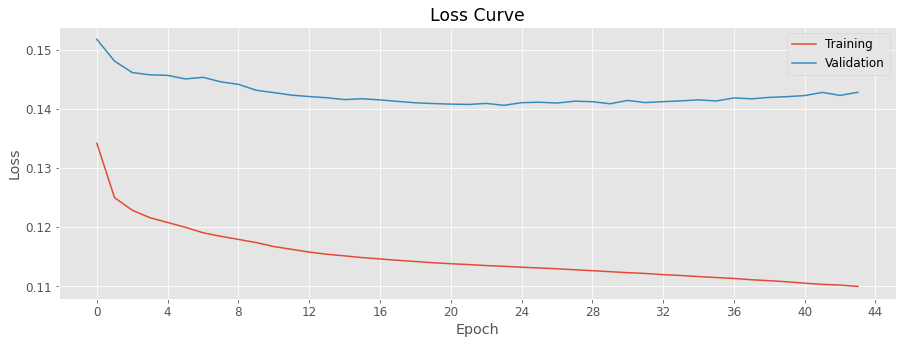

In [10]:
if retrain_lstm:
    # Create the model.
    lstm_model = create_lstm(lstm_trn['x'].shape[1:], 
                             lstm_trn['y'].shape[1],
                             **best_lstm_params)  
    lstm_model.summary()  

    # Defining some callbacks.
    save, graph = True, True
    callback_log = CSVLogger(log_dir, separator=',') 
    callbacks = [callback_log]
    if save:
        callback_cp = ModelCheckpoint(cp_dir, save_best_only=True, period=2,
                                      monitor='val_loss', mode='min')
        callbacks.append(callback_cp)
    if graph:
        max_idx = np.unravel_index(lstm_trn['y_orig'].argmax(), 
                                   lstm_trn['y_orig'].shape)
        callback_pp = PredictionsPlot(lstm_model, lstm_trn['x'], lstm_trn['y'], 
                                      length=154, idx=max_idx, period=5)
        callbacks.append(callback_pp)
    callback_es = EarlyStopping(monitor='val_loss', patience=20, 
                                mode='min', verbose=1)
    callbacks.append(callback_es)

    # Training...
    lstm_model.fit(lstm_trn['x'], lstm_trn['y'],
                   epochs=1000,
                   batch_size=best_lstm_batch_size,
                   validation_data=(lstm_val['x'], lstm_val['y']),
                   callbacks=callbacks,
                   shuffle=True)

lstm_model = load_model(cp_dir, custom_objects={'rmse_tf': rmse_tf})    
lstm_log = pd.read_csv(log_dir, delimiter=',')
lstm_model.summary()  
plot_loss(lstm_log['loss'], lstm_log['val_loss'])

#### Results

In [15]:
# Predicting...
lstm_trn['yhat'] = lstm_model.predict(lstm_trn['x'], batch_size=28)
lstm_val['yhat'] = lstm_model.predict(lstm_val['x'], batch_size=28)
lstm_tst['yhat'] = lstm_model.predict(lstm_tst['x'], batch_size=28)

# Predicting 28 days ahead...
lstm_tst28 = lstm_tst['tst'].copy()
lstm_tst28[-28:, :num_preds] = np.nan
for d in range(28):
    xtst = lstm_tst28[d: d + best_lstm_steps]
    pred = lstm_model.predict(np.expand_dims(xtst, axis=0))
    lstm_tst28[d + best_lstm_steps, :num_preds] = pred

In [16]:
# Inverse scaling the predictions.
lstm_trn['yhat_orig'] = np.zeros((lstm_trn['x'].shape[0], lstm_trn['x'].shape[2]))
lstm_trn['yhat_orig'][:, :num_preds] = lstm_trn['yhat']
lstm_trn['yhat_orig'] = lstm_scaler.inverse_transform(lstm_trn['yhat_orig'])[:, :num_preds]

lstm_val['yhat_orig'] = np.zeros((lstm_val['x'].shape[0], lstm_val['x'].shape[2]))
lstm_val['yhat_orig'][:, :num_preds] = lstm_val['yhat']
lstm_val['yhat_orig'] = lstm_scaler.inverse_transform(lstm_val['yhat_orig'])[:, :num_preds]

lstm_tst['yhat_orig'] = np.zeros((lstm_tst['x'].shape[0], lstm_tst['x'].shape[2]))
lstm_tst['yhat_orig'][:, :num_preds] = lstm_tst['yhat']
lstm_tst['yhat_orig'] = lstm_scaler.inverse_transform(lstm_tst['yhat_orig'])[:, :num_preds]

lstm_tst['yhat28_orig'] = lstm_scaler.inverse_transform(lstm_tst28)[-28:, :num_preds]

In [17]:
# Mean Error
print('Train ME: %f' % mean_error(lstm_trn['y_orig'], lstm_trn['yhat_orig']))
print('Validation ME: %f' % mean_error(lstm_val['y_orig'], lstm_val['yhat_orig']))
print('Test ME: %f' % mean_error(lstm_tst['y_orig'], lstm_tst['yhat_orig']))
print('Test ME (28-days ahead): %f' % mean_error(lstm_tst['y_orig'], lstm_tst['yhat28_orig']))

Train ME: 0.021394
Validation ME: -0.008565
Test ME: -0.103332
Test ME (28-days ahead): -0.109910


In [18]:
# Root Mean Square Error
print('Train RMSE: %f' % rmse(lstm_trn['y_orig'], lstm_trn['yhat_orig']))
print('Validation RMSE: %f' % rmse(lstm_val['y_orig'], lstm_val['yhat_orig']))
print('Test RMSE: %f' % rmse(lstm_tst['y_orig'], lstm_tst['yhat_orig']))
print('Test RMSE (28-days ahead): %f' % rmse(lstm_tst['y_orig'], lstm_tst['yhat28_orig']))

Train RMSE: 2.106566
Validation RMSE: 2.114948
Test RMSE: 2.249158
Test RMSE (28-days ahead): 2.277803


In [19]:
# Root Mean Square Scaled Error
print('Train RMSSE: %f' % rmsse(lstm_trn['y_orig'], lstm_trn['yhat_orig']))
print('Validation RMSSE: %f' % rmsse(lstm_val['y_orig'], lstm_val['yhat_orig']))
print('Test RMSSE: %f' % rmsse(lstm_tst['y_orig'], lstm_tst['yhat_orig']))

# For the 28-days ahead forecast, we set the naive predictions to be the same as 
# the previous 28 days, which is the same as the target values for the validation set.
naive_preds = lstm_val['y_orig'] 
print('Test RMSSE (28-days ahead): %f' % rmsse(lstm_tst['y_orig'], lstm_tst['yhat28_orig'], 
                                               lstm_tst['y_orig'], naive_preds))

Train RMSSE: 0.783195
Validation RMSSE: 0.823715
Test RMSSE: 0.856767
Test RMSSE (28-days ahead): 0.805114


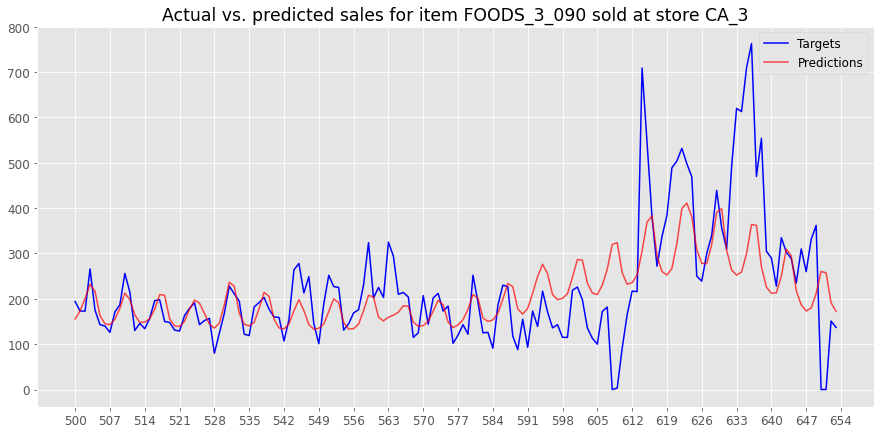

In [20]:
item_idx = 'FOODS_3_090_CA_3_evaluation'
ids = sales['id'].values
idx = np.where(ids == item_idx)[0][0]
start = 500
length = 154
end = start + length

plt.figure(figsize=(15, 7))
plt.plot(lstm_trn['y_orig'][start:end, idx], 
         alpha=1, label='Targets', c='b')
plt.plot(lstm_trn['yhat_orig'][start:end, idx], 
         alpha=0.7, label='Predictions', c='r')
plt.xticks(ticks=np.arange(0, length+1, 7), labels=np.arange(start, end+1, 7))
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')

plt.legend()
plt.show()

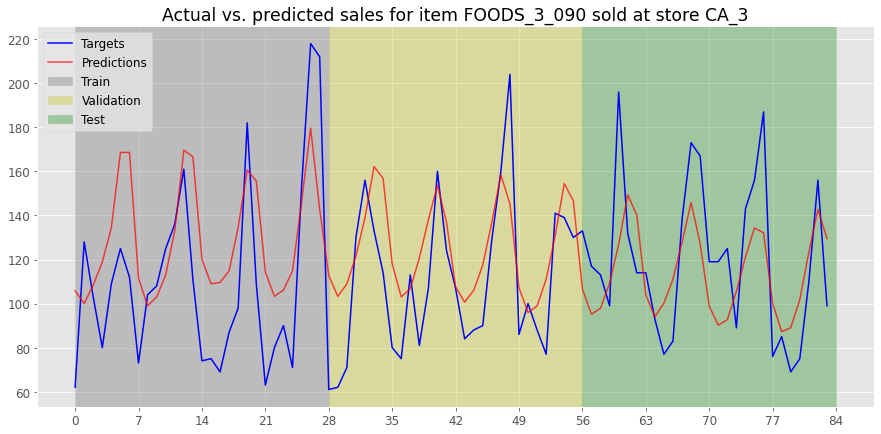

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(np.append(lstm_trn['y_orig'][-28:, idx], 
                   [lstm_val['y_orig'][:, idx], 
                    lstm_tst['y_orig'][:, idx]]), 
         alpha=1, label='Targets', c='b')
plt.plot(np.append(lstm_trn['yhat_orig'][-28:, idx], 
                   [lstm_val['yhat_orig'][:, idx], 
                    lstm_tst['yhat_orig'][:, idx]]), 
         alpha=0.7, label='Predictions', c='r')
plt.axvspan(0, 28, color='grey', alpha=0.4, label='Train')
plt.axvspan(28, 28 + len(lstm_val['y']), color='y', alpha=0.3, label='Validation')
plt.axvspan(28 + len(lstm_val['y']), 28 + len(lstm_val['y']) + len(lstm_tst['y']), 
            color='g', alpha=0.3, label='Test')
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, 29 + len(lstm_val['y']) + len(lstm_tst['y']), 7))

plt.legend()
plt.show()

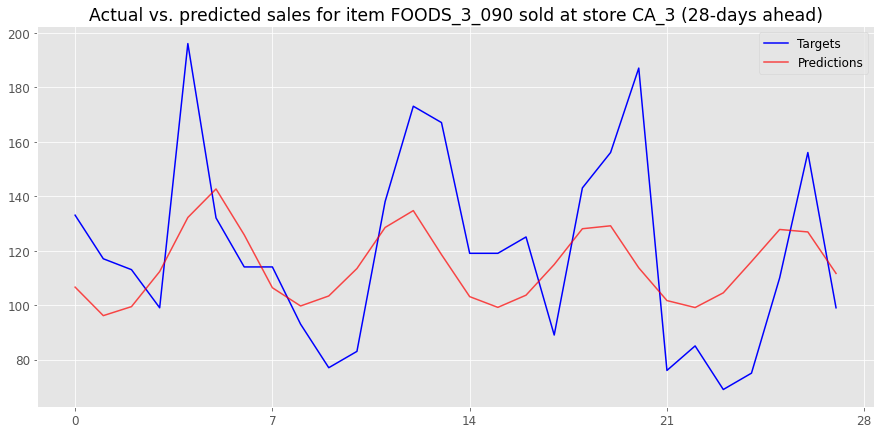

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(lstm_tst['y_orig'][:, idx], 
         alpha=1, label='Targets', c='b')
plt.plot(lstm_tst['yhat28_orig'][:, idx], 
         alpha=0.7, label='Predictions', c='r')
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3 (28-days ahead)')
plt.xticks(ticks=np.arange(0, len(lstm_tst['y']) + 1, 7))

plt.legend()
plt.show()

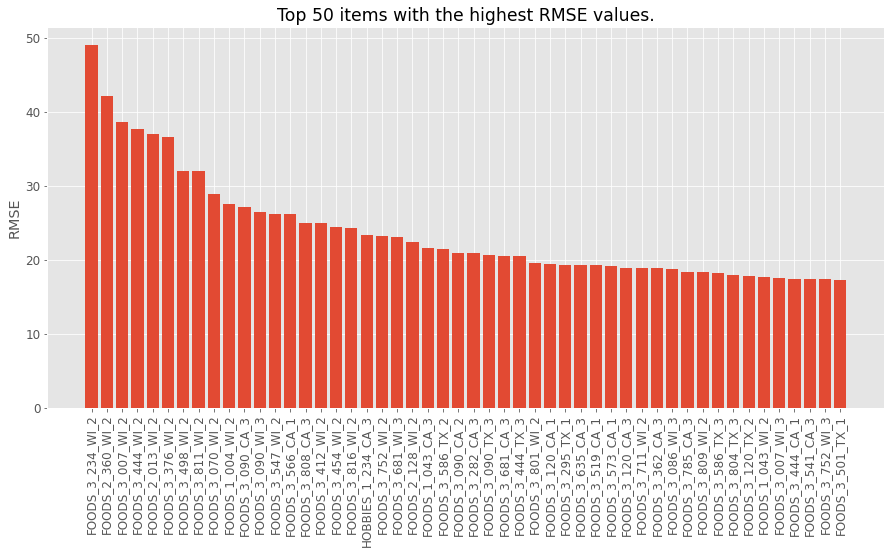

In [23]:
items = [x[:-11] for x in sales['id'].values]
rmse_cols = []
for col in tqdm(range(lstm_tst['y_orig'].shape[1])):
    rmse_cols.append(rmse(lstm_tst['y_orig'][:, col], 
                          lstm_tst['yhat_orig'][:, col]))
rmse_cols = pd.DataFrame(rmse_cols, index=items)
rmse_cols = rmse_cols.sort_values(by=0, ascending=False)
top_50 = rmse_cols.iloc[:50]

plt.figure(figsize=(15, 7))
plt.bar(top_50.index, top_50[0])
plt.xticks(rotation=90)
plt.title('Top 50 items with the highest RMSE values.')
plt.ylabel('RMSE')
plt.show()

### Multi-Layer Perceptron

In [4]:
# Whether to retrain the model or load a previously saved model.
reoptimize_ann = 0
retrain_ann = 0
model_dir = proj_dir + 'models/ann/'
cp_dir = model_dir + 'ann_best.h5'
log_dir = model_dir + 'ann_log.csv'
opt_dir = model_dir + 'ann_optimizer.json'

lags = [0, 7, 14, 28]
window_sizes = [7, 14, 28]

#### Model Creation

In [5]:
def create_ann(in_shape,
               out_shape,
               n_layers=1,
               last_units=64,
               units_decay=1,
               hidden_sizes=None,
               learning_rate=0.001, 
               lr_decay=0.0,
               dropout_rate=0.1,
               norm=0):
    """
    Creates a multilayer perceptron model.
    
    :param in_shape: The shape of the input data.
    :param out_shape: The shape of the model output.
    :param n_layers: The number of hidden dense layers.
    :param last_units: The number of units for the last hidden dense layer.
    :param units_decay: The decay rate of the number of units going from last hidden layer to the first.
    :param hidden_sizes: A list containing the number of nodes for each hidden dense layer. This is meant to be used as 
        an alternative to n_layers, n_units, and units_scale to specify the number of hidden layers and the number of 
        nodes per hidden layer.
    :param learning_rate: The learning rate of the model.
    :param lr_decay: The learning rate decay of the model.
    :param dropout_rate: The dropout rate for the dropout layers.
    :param norm: Whether to use a batch normalization layer after each dense layer or not.
    

    :return An MLP model.
    """
    kb.clear_session()
    tf.compat.v1.reset_default_graph()
    kb.clear_session()

    n_layers = int(n_layers)
    last_units = int(last_units)
    norm = round(norm)
    model = Sequential()

    # Adding the input and hidden layers.
    if hidden_sizes is not None:
        for i_layer, i_units in enumerate(hidden_sizes):
            if i_layer == 0:
                model.add(Dense(i_units, activation='relu',
                                input_shape=in_shape))
            else:
                model.add(Dense(i_units, activation='relu'))                
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate)) 
    else:
        for i_layer in range(n_layers):
            if i_layer == 0:
                model.add(Dense(max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                                activation='relu', 
                                input_shape=in_shape))
            else:
                model.add(Dense(max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                                activation='relu'))                
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate)) 
                
    # Adding the output layer
    model.add(Dense(units=out_shape))

    model.compile(optimizer=optimizers.Adam(lr=learning_rate, decay=lr_decay), 
                  loss=rmse_tf)
    
    return model

def score_ann(trn, val, **model_params): 
    """
    Trains an MLP model on the given training data and returns its score on the given validation data.
    
    :param trn: The training data.
    :param val: The validation data.
    :param model_params: The parameters of the MLP model.

    :return The score of the MLP model on the given validation data.
    """
    batch_size = int(model_params.pop('batch_size'))                        
    # Create the model...
    callback_es = EarlyStopping(monitor='val_loss', patience=10, 
                                mode='min', verbose=2)
    model = create_ann(in_shape=trn['x'].shape[1:],
                       out_shape=1,
                       **model_params)
    log = model.fit(trn['x'], trn['y'],
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(val['x'], val['y']),
                    callbacks=[callback_es],
                    shuffle=True,
                    verbose=0)
    score = min(log.history['val_loss'])
    del model
    gc.collect()

    return -score

#### Hyperparameter Optimization

In [6]:
if reoptimize_ann:
    cont_opt = True
    # Defining hyperparameters ranges for optimization.
    n_layers = (3, 5.99)
    last_units = (64, 512)
    units_decay = (0.2, 1)
    learning_rate = (1e-4, 1e-2)
    lr_decay = (0, 1e-3)
    dropout_rate = (0, 0.3)
    norm = (0, 1)
    batch_size = (32000, 100000)

    param_bounds = dict(n_layers=n_layers,
                        last_units=last_units,
                        units_decay=units_decay,
                        learning_rate=learning_rate, 
                        lr_decay=lr_decay,
                        dropout_rate=dropout_rate,
                        norm=norm,
                        batch_size=batch_size)

    data = row_wise_dataprep(data=sales, lags=lags, 
                             window_sizes=window_sizes, 
                             load=True)
    trn, val, _ = row_wise_train_test_split(data,
                                            val_days=28, 
                                            tst_days=28).values()
    del data
    
    scorer = partial(score_ann, trn, val)
    transformer = SequentialDomainReductionTransformer(gamma_osc=0.8, eta=0.95)
    optimizer = BayesianOptimization(f=scorer,
                                     pbounds=param_bounds,
                                     verbose=2,
                                     bounds_transformer=transformer)
    if cont_opt:
        load_logs(optimizer, logs=[opt_dir])

    scr_logger = ScreenLogger()
    f_logger = JSONLogger(path=opt_dir, reset=False if cont_opt else True)
    optimizer.subscribe(Events.OPTIMIZATION_START, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_END, scr_logger)    
    optimizer.subscribe(Events.OPTIMIZATION_STEP, f_logger)

    if not cont_opt:    
        optimizer.probe(lazy=True,
                        params={'n_layers': 4, 
                                'last_units': 128,
                                'units_decay': 1,
                                'learning_rate': 0.001,
                                'lr_decay': 0,
                                'dropout_rate': 0.1,
                                'norm': 1,
                                'batch_size': 1e5})
        
    optimizer.maximize(init_points=25, n_iter=100, alpha=1e-4, kappa=3)

else:
    errors, params = [], []
    with open(opt_dir, 'r') as f:
        opt_hist = f.readlines()
    for line in opt_hist:
        print(line, end='')
        hist = json.loads(line)
        errors.append(hist['target'])
        params.append(hist['params'])

{"target": -2.302182912826538, "params": {"batch_size": 100000.0, "dropout_rate": 0.1, "last_units": 128.0, "learning_rate": 0.001, "lr_decay": 0.0, "n_layers": 4.0, "norm": 1.0, "units_decay": 1.0}}
{"target": -2.270049571990967, "params": {"batch_size": 85736.00768161437, "dropout_rate": 0.06459084754244197, "last_units": 215.31424822209752, "learning_rate": 0.0031564054163509066, "lr_decay": 0.00045596650726610887, "n_layers": 3.5540399607269606, "norm": 0.47206804479852194, "units_decay": 0.6693834305920554}}
{"target": -2.280794858932495, "params": {"batch_size": 40858.522991766135, "dropout_rate": 0.16251364855115066, "last_units": 382.87291666984606, "learning_rate": 0.007986067058516759, "lr_decay": 0.0008627649291823811, "n_layers": 4.622768412474855, "norm": 0.7847072595037853, "units_decay": 0.6804392400826977}}
{"target": -2.3078420162200928, "params": {"batch_size": 82835.43861421062, "dropout_rate": 0.07972548872778348, "last_units": 203.6405274136807, "learning_rate": 0.

#### Model Training

In [7]:
best_iter = np.argmax(errors)
best_ann_params = params[best_iter].copy()
print('Best Hyperparameters:', json.dumps(best_ann_params, indent=1))
best_ann_batch_size = int(best_ann_params.pop('batch_size'))

Best Hyperparameters: {
 "batch_size": 57798.87249946412,
 "dropout_rate": 0.006265521155540071,
 "last_units": 467.9103920676094,
 "learning_rate": 0.004513522114904016,
 "lr_decay": 0.00047784007756409907,
 "n_layers": 4.85420651019103,
 "norm": 0.18130266913128562,
 "units_decay": 0.69908813500555
}


In [8]:
ann_data = row_wise_dataprep(data=sales, 
                             lags=lags, 
                             window_sizes=window_sizes, 
                             load=True)
ann_trn, ann_val, ann_tst = row_wise_train_test_split(ann_data,
                                                      val_days=28, 
                                                      tst_days=28).values()

print(ann_trn['x'].info())                                                     
print('\nTraining:', ann_trn['x'].shape, ann_trn['y'].shape)
print('Validation:', ann_val['x'].shape, ann_val['y'].shape)
print('Test:', ann_tst['x'].shape, ann_tst['y'].shape)

Loading preprocessed data from file... 
Separating train, validation, and test sets...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37654413 entries, 935203 to 40681253
Data columns (total 25 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       int16  
 1   dept_id       int8   
 2   cat_id        int8   
 3   store_id      int8   
 4   state_id      int8   
 5   d             int16  
 6   wday          int8   
 7   month         int8   
 8   year          int16  
 9   event_name_1  int8   
 10  snap_CA       int8   
 11  snap_TX       int8   
 12  snap_WI       int8   
 13  sell_price    float16
 14  lag_0         float16
 15  lag_7         float16
 16  lag_14        float16
 17  lag_28        float16
 18  rmean_7       float16
 19  rstd_7        float16
 20  rmean_14      float16
 21  rstd_14       float16
 22  rmean_28      float16
 23  rstd_28       float16
 24  events_tomo   int8   
dtypes: float16(11), int16(3), int8(11)
memory usage: 1.6 GB
Non

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 159)               4134      
_________________________________________________________________
dropout_1 (Dropout)          (None, 159)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 228)               36480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 228)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 326)               74654     
_________________________________________________________________
dropout_3 (Dropout)          (None, 326)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 467)              

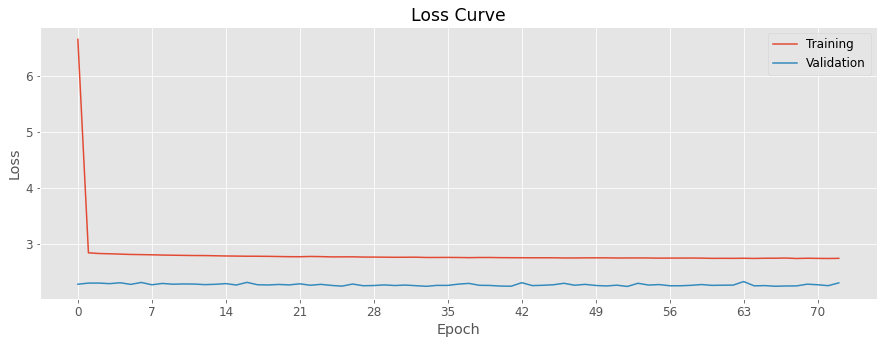

In [9]:
if retrain_ann:
    # Create the model
    ann_model = create_ann(in_shape=ann_trn['x'].shape[1:], 
                           out_shape=1,
                           **best_ann_params)  
    ann_model.summary()  

    # Defining some callbacks.
    save = True
    callback_log = CSVLogger(log_dir, separator=',') 
    callbacks = [callback_log]
    if save:
        callback_cp = ModelCheckpoint(cp_dir, save_best_only=True, period=1,
                                      monitor='val_loss', mode='min')
        callbacks.append(callback_cp)
    callback_es = EarlyStopping(monitor='val_loss', patience=20,
                                mode='min', verbose=1)
    callbacks.append(callback_es)

    # Fitting the ANN to the training set.
    ann_model.fit(ann_trn['x'], ann_trn['y'],
                   epochs=1000,
                   batch_size=best_ann_batch_size,
                   validation_data=(ann_val['x'], ann_val['y']),
                   callbacks=callbacks,
                   shuffle=True)

ann_model = load_model(cp_dir, custom_objects={'rmse_tf': rmse_tf})    
ann_log = pd.read_csv(log_dir, delimiter=',')
ann_model.summary()  
plot_loss(ann_log['loss'], ann_log['val_loss'])

#### Results

In [10]:
ann_trn['yhat'] = ann_model.predict(ann_trn['x'], batch_size=100_000)[:, 0]
ann_val['yhat'] = ann_model.predict(ann_val['x'], batch_size=100_000)[:, 0]
ann_tst['yhat'] = ann_model.predict(ann_tst['x'], batch_size=100_000)[:, 0]

In [11]:
# Mean Error
print('Training ME: %f' % mean_error(ann_trn['y'], ann_trn['yhat']))
print('Validation ME: %f' % mean_error(ann_val['y'], ann_val['yhat']))
print('Test ME: %f' % mean_error(ann_tst['y'], ann_tst['yhat']))

Training ME: -0.056449
Validation ME: -0.036434
Test ME: -0.085676


In [12]:
# Root Mean Square Error
print('Training RMSE: %f' % rmse(ann_trn['y'], ann_trn['yhat']))
print('Validation RMSE: %f' % rmse(ann_val['y'], ann_val['yhat']))
print('Test RMSE: %f' % rmse(ann_tst['y'], ann_tst['yhat']))

Training RMSE: 2.738884
Validation RMSE: 2.244670
Test RMSE: 2.293761


In [13]:
# Root Mean Square Scaled Error
naive_ytrn_hat = pd.concat([ann_trn['x'], ann_trn['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales']\
                   .shift(1)
naive_yval_hat = pd.concat([ann_val['x'], ann_val['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales']\
                   .shift(1)
naive_ytst_hat = pd.concat([ann_tst['x'], ann_tst['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales']\
                   .shift(1)

print('Training RMSSE: %f' % rmsse(ann_trn['y'], ann_trn['yhat'], 
                                   ann_trn['y'][~pd.isna(naive_ytrn_hat)], 
                                   naive_ytrn_hat[~pd.isna(naive_ytrn_hat)]))
print('Validation RMSSE: %f' % rmsse(ann_val['y'], ann_val['yhat'], 
                                     ann_val['y'][~pd.isna(naive_yval_hat)], 
                                     naive_yval_hat[~pd.isna(naive_yval_hat)]))
print('Test RMSSE: %f' % rmsse(ann_tst['y'], ann_tst['yhat'], 
                               ann_tst['y'][~pd.isna(naive_ytst_hat)], 
                               naive_ytst_hat[~pd.isna(naive_ytst_hat)]))
print('Test RMSSE (28-days ahead): %f' % rmsse(ann_tst['y'], ann_tst['yhat'], 
                                               ann_tst['y'], ann_tst['x']['lag_0']))

Training RMSSE: 0.940492
Validation RMSSE: 0.874214
Test RMSSE: 0.873757
Test RMSSE (28-days ahead): 0.810755


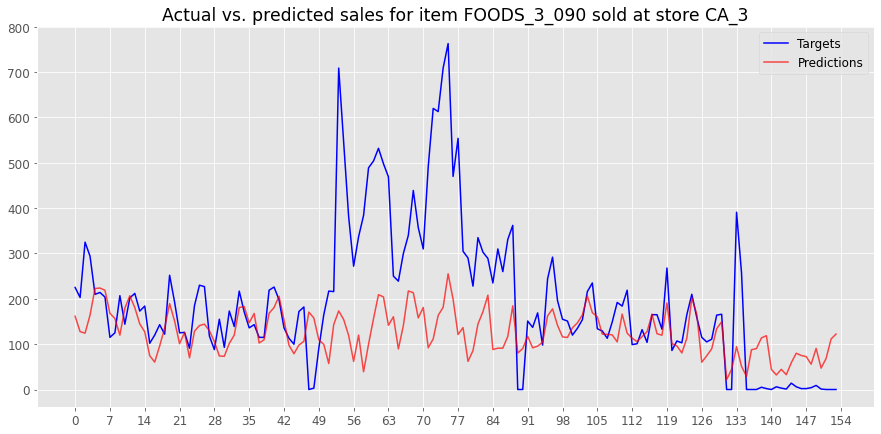

In [14]:
store_idx = 2
item_idx = 702
start = 500
length = 154
end = start + length

plt.figure(figsize=(15, 7))
g_trn = pd.concat([ann_trn['x'][['store_id', 'item_id']], ann_trn['y'],
                   pd.Series(ann_trn['yhat'].reshape(-1), 
                             name='preds', 
                             index=ann_trn['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])

sample_ytrn = g_trn['sales'].apply(list).loc[(store_idx, item_idx)]
sample_ytrn_hat = g_trn['preds'].apply(list).loc[(store_idx, item_idx)]

plt.plot(sample_ytrn[start: end], 
         alpha=1, label='Targets', c='b')
plt.plot(sample_ytrn_hat[start: end], 
         alpha=0.7, label='Predictions', c='r')

plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, length + 1, 7))

plt.legend()
plt.show()

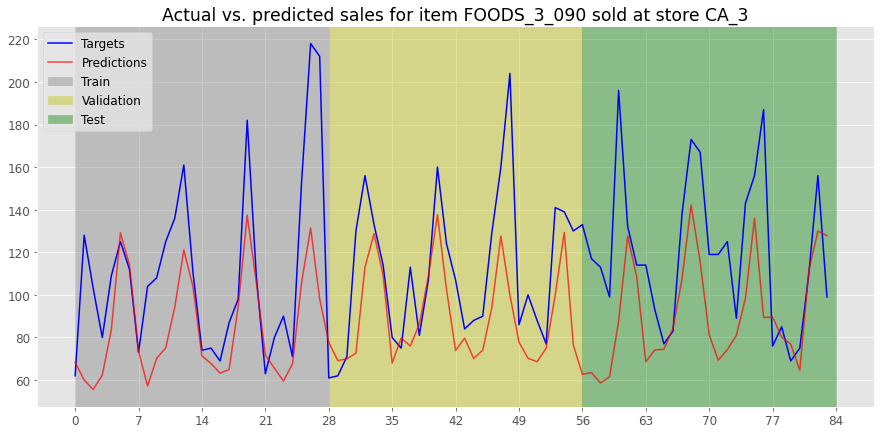

In [15]:
plt.figure(figsize=(15, 7))

g_val = pd.concat([ann_val['x'][['store_id', 'item_id']], ann_val['y'],
                   pd.Series(ann_val['yhat'].reshape(-1), 
                             name='preds', 
                             index=ann_val['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])
g_tst = pd.concat([ann_tst['x'][['store_id', 'item_id']], ann_tst['y'],
                   pd.Series(ann_tst['yhat'].reshape(-1), 
                             name='preds', 
                             index=ann_tst['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])

sample_yval = g_val['sales'].apply(list).loc[(store_idx, item_idx)]
sample_ytst = g_tst['sales'].apply(list).loc[(store_idx, item_idx)]
sample_yval_hat = g_val['preds'].apply(list).loc[(store_idx, item_idx)]
sample_ytst_hat = g_tst['preds'].apply(list).loc[(store_idx, item_idx)]

plt.plot(sample_ytrn[-28:] + sample_yval + sample_ytst, 
         alpha=1, label='Targets', c='b')
plt.plot(sample_ytrn_hat[-28:] + sample_yval_hat + sample_ytst_hat, 
         alpha=0.7, label='Predictions', c='r')


plt.axvspan(0, 28, color='grey', alpha=0.4, label='Train')
plt.axvspan(28, 28 + len(sample_yval), 
            color='y', alpha=0.4, label='Validation')
plt.axvspan(28 + len(sample_yval), 28 + len(sample_yval) + len(sample_ytst), 
            color='g', alpha=0.4, label='Test')

plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, 29 + len(sample_yval) + len(sample_ytst), 7))

plt.legend()
plt.show()

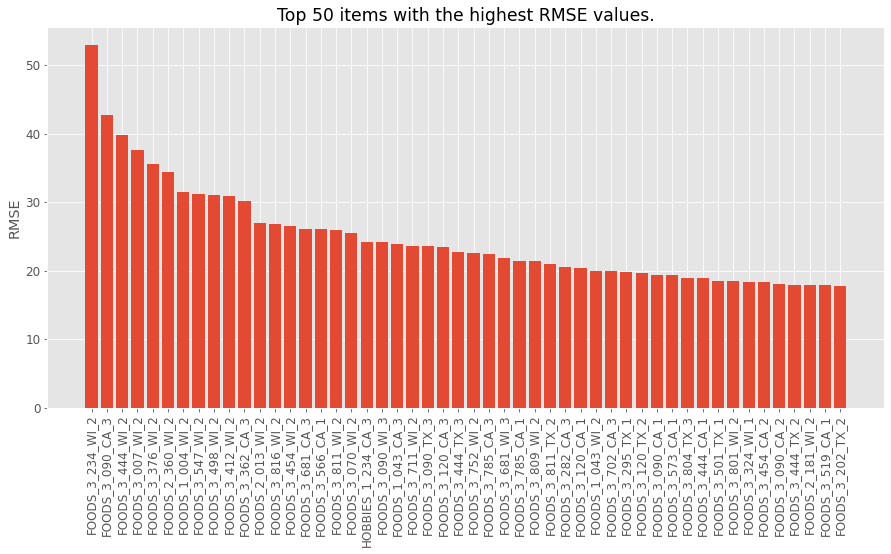

In [16]:
g_tst = pd.concat([ann_tst['x'][['store_id', 'item_id']], ann_tst['y'],
                   pd.Series(ann_tst['yhat'].reshape(-1), 
                             name='preds', 
                             index=ann_tst['y'].index)], 
                  axis=1).join(ann_data['id']).drop(columns=['store_id', 'item_id'])
g_tst = g_tst.groupby(['id'])
errors = g_tst.apply(lambda r: rmse(r['sales'], r['preds'])).sort_values(ascending=False)
top_50 = errors[:50]
items = [x[:-11] for x in top_50.index]

plt.figure(figsize=(15, 7))
plt.bar(items, top_50.values)
plt.xticks(rotation=90)
plt.title('Top 50 items with the highest RMSE values.')
plt.ylabel('RMSE')
plt.show()

### LightGBM

In [4]:
# Whether to retrain the model or load a previously saved model.
reoptimize_lgbm = 0
retrain_lgbm = 0
model_dir = proj_dir + 'models/lgbm/'
cp_dir = model_dir + 'lgbm_best.txt'
log_dir = model_dir + 'lgbm_log.csv'
opt_dir = model_dir + 'lgbm_optimizer.json'

lags = [0, 7, 14, 28]
window_sizes = [7, 14, 28]

#### Model Creation

In [5]:
def score_lgbm(datasets, fixed_params, **model_params):   
    """
    Trains an LGBM model on the given training dataset and returns its score on the given validation dataset.
    
    :param datasets: A dictionary containing LGBM training and validation datasets.
    :param model_params: The parameters of the LGBM model.

    :return The score of the LGBM model on the given validation dataset.
    """
    # Create the model...
    log = {} 
    model_params['num_leaves'] = int(model_params['num_leaves'])
    model_params['min_data_in_leaf'] = int(model_params['min_data_in_leaf'])
    model_params.update(fixed_params)

    model = lgb.train(model_params, 
                      datasets['trn'], 
                      valid_sets=[datasets['val']],
                      callbacks=[lgb.record_evaluation(log),
                                 lgb.early_stopping(10)], 
                      verbose_eval=False)
    score = min(log['valid_0']['rmse'])
    del model
    gc.collect()

    return -score

#### Hyperparameter Optimization

In [6]:
if reoptimize_lgbm:
    cont_opt = True
    # Fixed hyperparameters
    fixed_params = {
        'objective' : 'regression',
        'boosting': 'gbdt',
        'metric' : 'rmse',
        'num_iterations' : 100,
        'force_row_wise' : True,
        'num_threads' : 6
    }

    # Defining hyperparameters ranges for optimization.
    learning_rate = (1e-3, 0.5)
    feature_fraction = (0.2, 1)
    lambda_l2 = (0, 0.3)
    num_leaves = (50, 5000)
    min_data_in_leaf = (10, 5000)

    param_bounds = dict(learning_rate=learning_rate,
                        feature_fraction=feature_fraction,
                        lambda_l2=lambda_l2,
                        num_leaves=num_leaves,
                        min_data_in_leaf=min_data_in_leaf)

    data = row_wise_dataprep(data=sales, 
                             lags=lags, 
                             window_sizes=window_sizes,
                             load=True)
    trn, val, _ = row_wise_train_test_split(data,
                                            val_days=28,
                                            tst_days=28).values()
    datasets = prepare_lgbm_training_datasets(trn, val)
    del data, trn, val
    
    scorer = partial(score_lgbm, datasets, fixed_params)
    transformer = SequentialDomainReductionTransformer(gamma_osc=0.8, eta=0.95)
    optimizer = BayesianOptimization(f=scorer,
                                     pbounds=param_bounds,
                                     verbose=2,
                                     bounds_transformer=transformer)
    if cont_opt:
        load_logs(optimizer, logs=[opt_dir])

    scr_logger = ScreenLogger()
    f_logger = JSONLogger(path=opt_dir, reset=False if cont_opt else True)
    optimizer.subscribe(Events.OPTIMIZATION_START, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, scr_logger)
    optimizer.subscribe(Events.OPTIMIZATION_END, scr_logger)    
    optimizer.subscribe(Events.OPTIMIZATION_STEP, f_logger)

    optimizer.maximize(init_points=25, n_iter=200, alpha=1e-5)

else:
    errors, params = [], []
    with open(opt_dir, 'r') as f:
        opt_hist = f.readlines()
    for line in opt_hist:
        print(line, end='')
        hist = json.loads(line)
        errors.append(hist['target'])
        params.append(hist['params'])

{"target": -2.158078630453213, "params": {"feature_fraction": 0.7554557521091222, "lambda_l2": 0.29592558912855726, "learning_rate": 0.27767886522764523, "min_data_in_leaf": 352.50715828719416, "num_leaves": 3029.1068650052794}}
{"target": -2.1703577976536264, "params": {"feature_fraction": 0.8067882519762019, "lambda_l2": 0.24693068541021532, "learning_rate": 0.40739284326488645, "min_data_in_leaf": 4251.900079390875, "num_leaves": 3204.229564859031}}
{"target": -2.1497428983279967, "params": {"feature_fraction": 0.9431220040570854, "lambda_l2": 0.29723951373146174, "learning_rate": 0.3014185621817614, "min_data_in_leaf": 4808.387638381709, "num_leaves": 1230.5297331120553}}
{"target": -2.170942942533649, "params": {"feature_fraction": 0.7483526693606605, "lambda_l2": 0.02935751096978223, "learning_rate": 0.3949728117814148, "min_data_in_leaf": 855.4214002126456, "num_leaves": 3439.8978347922416}}
{"target": -2.1748328268606256, "params": {"feature_fraction": 0.7755617088283351, "lamb

#### Model Training

In [7]:
best_iter = np.argmax(errors)
best_lgbm_params = params[best_iter].copy()
print('Best Hyperparameters:', json.dumps(best_lgbm_params, indent=1))
best_lgbm_params['num_leaves'] = int(best_lgbm_params['num_leaves'])
best_lgbm_params['min_data_in_leaf'] = int(best_lgbm_params['min_data_in_leaf'])

Best Hyperparameters: {
 "feature_fraction": 0.553332400822897,
 "lambda_l2": 0.21955370052423398,
 "learning_rate": 0.09789220144755495,
 "min_data_in_leaf": 749.2105146034442,
 "num_leaves": 1534.9826196637728
}


In [8]:
lgbm_data = row_wise_dataprep(data=sales, 
                              lags=lags, 
                              window_sizes=window_sizes,
                              load=True)
lgbm_trn, lgbm_val, lgbm_tst = row_wise_train_test_split(lgbm_data,
                                                         val_days=28,
                                                         tst_days=28).values()
print(lgbm_trn['x'].info())                                                     
lgbm_datasets = prepare_lgbm_training_datasets(lgbm_trn, lgbm_val)

Loading preprocessed data from file... 
Separating train, validation, and test sets...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37654413 entries, 935203 to 40681253
Data columns (total 25 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       int16  
 1   dept_id       int8   
 2   cat_id        int8   
 3   store_id      int8   
 4   state_id      int8   
 5   d             int16  
 6   wday          int8   
 7   month         int8   
 8   year          int16  
 9   event_name_1  int8   
 10  snap_CA       int8   
 11  snap_TX       int8   
 12  snap_WI       int8   
 13  sell_price    float16
 14  lag_0         float16
 15  lag_7         float16
 16  lag_14        float16
 17  lag_28        float16
 18  rmean_7       float16
 19  rstd_7        float16
 20  rmean_14      float16
 21  rstd_14       float16
 22  rmean_28      float16
 23  rstd_28       float16
 24  events_tomo   int8   
dtypes: float16(11), int16(3), int8(11)
memory usage: 1.6 GB
Non

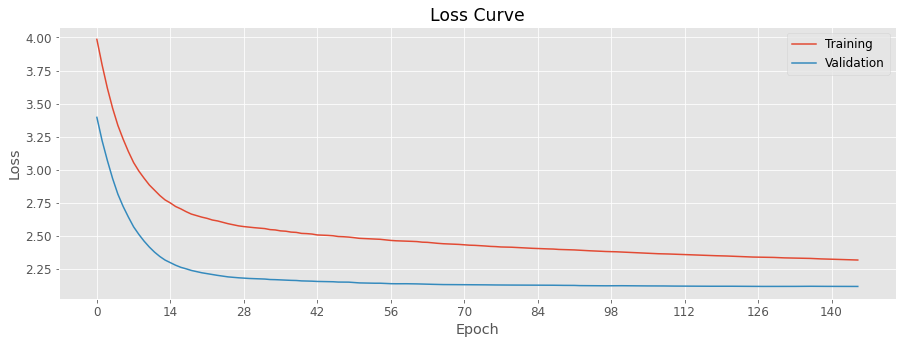

In [9]:
if retrain_lgbm:
    fixed_params = {
        'objective' : 'regression',
        'boosting': 'gbdt',
        'metric' : 'rmse',
        'num_iterations' : 1000,
        'force_row_wise' : True,
        'num_threads' : 6
    }
    best_lgbm_params.update(fixed_params)
    lgbm_log = {}
    lgbm_model = lgb.train(best_lgbm_params, 
                           lgbm_datasets['trn'], 
                           valid_sets=[lgbm_datasets['trn'],
                                       lgbm_datasets['val']], 
                           verbose_eval=5,
                           callbacks=[lgb.record_evaluation(lgbm_log),
                                      lgb.early_stopping(20, verbose=True)])

    model_best_epoch = np.argmin(lgbm_log['valid_1']['rmse'])
    lgbm_model.save_model(cp_dir, num_iteration=model_best_epoch)
    with open(log_dir, 'wb') as f:
        pickle.dump(lgbm_log, f)

lgbm_model = lgb.Booster(model_file=cp_dir)
with open(log_dir, 'rb') as f:
    lgbm_log = pickle.load(f)

plot_loss(lgbm_log['training']['rmse'], lgbm_log['valid_1']['rmse'])

#### Results

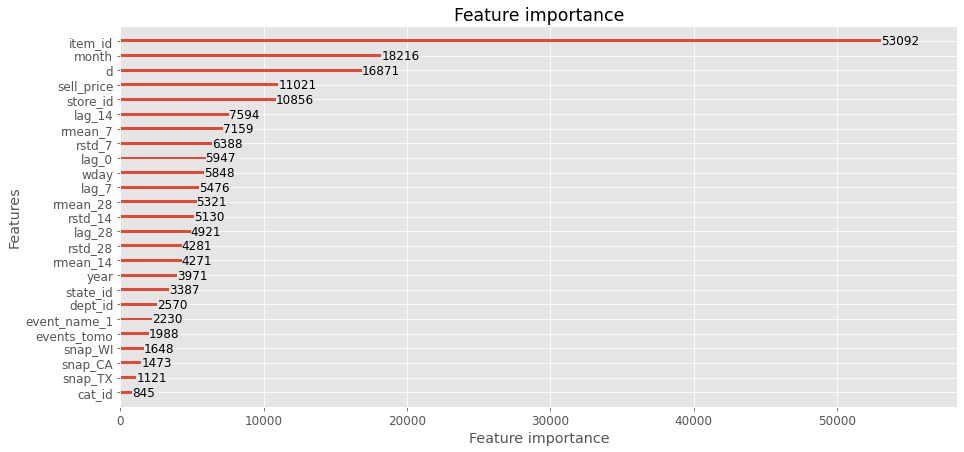

In [10]:
lgb.plot_importance(lgbm_model, figsize=(15, 7))
plt.show()

In [11]:
lgbm_trn['yhat'] = lgbm_model.predict(lgbm_trn['x'], num_thread=6)
lgbm_val['yhat'] = lgbm_model.predict(lgbm_val['x'], num_thread=6)
lgbm_tst['yhat'] = lgbm_model.predict(lgbm_tst['x'], num_thread=6)

In [12]:
# Mean Error
print('Training ME: %f' % mean_error(lgbm_trn['y'], lgbm_trn['yhat']))
print('Validation ME: %f' % mean_error(lgbm_val['y'], lgbm_val['yhat']))
print('Test ME: %f' % mean_error(lgbm_tst['y'], lgbm_tst['yhat']))

Training ME: -0.000014
Validation ME: -0.006792
Test ME: -0.070563


In [13]:
# Root Mean Square Error
print('Training RMSE: %f' % rmse(lgbm_trn['y'], lgbm_trn['yhat']))
print('Validation RMSE: %f' % rmse(lgbm_val['y'], lgbm_val['yhat']))
print('Test RMSE: %f' % rmse(lgbm_tst['y'], lgbm_tst['yhat']))

Training RMSE: 2.342242
Validation RMSE: 2.119327
Test RMSE: 2.186479


In [14]:
# Root Mean Square Scaled Error
naive_ytrn_hat = pd.concat([lgbm_trn['x'], lgbm_trn['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales'].shift(1)
naive_yval_hat = pd.concat([lgbm_val['x'], lgbm_val['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales'].shift(1)
naive_ytst_hat = pd.concat([lgbm_tst['x'], lgbm_tst['y']], axis=1)[['item_id', 'store_id', 'sales']]\
                   .groupby(['item_id', 'store_id'])['sales'].shift(1)

print('Training RMSSE: %f' % rmsse(lgbm_trn['y'], lgbm_trn['yhat'], 
                                   lgbm_trn['y'][~pd.isna(naive_ytrn_hat)], 
                                   naive_ytrn_hat[~pd.isna(naive_ytrn_hat)]))
print('Validation RMSSE: %f' % rmsse(lgbm_val['y'], lgbm_val['yhat'], 
                                     lgbm_val['y'][~pd.isna(naive_yval_hat)], 
                                     naive_yval_hat[~pd.isna(naive_yval_hat)]))
print('Test RMSSE: %f' % rmsse(lgbm_tst['y'], lgbm_tst['yhat'], 
                               lgbm_tst['y'][~pd.isna(naive_ytst_hat)], 
                               naive_ytst_hat[~pd.isna(naive_ytst_hat)]))
print('Test RMSSE (28-days ahead): %f' % rmsse(lgbm_tst['y'], lgbm_tst['yhat'], 
                                               lgbm_tst['y'], lgbm_tst['x']['lag_0']))

Training RMSSE: 0.804291
Validation RMSSE: 0.825397
Test RMSSE: 0.832890
Test RMSSE (28-days ahead): 0.772834


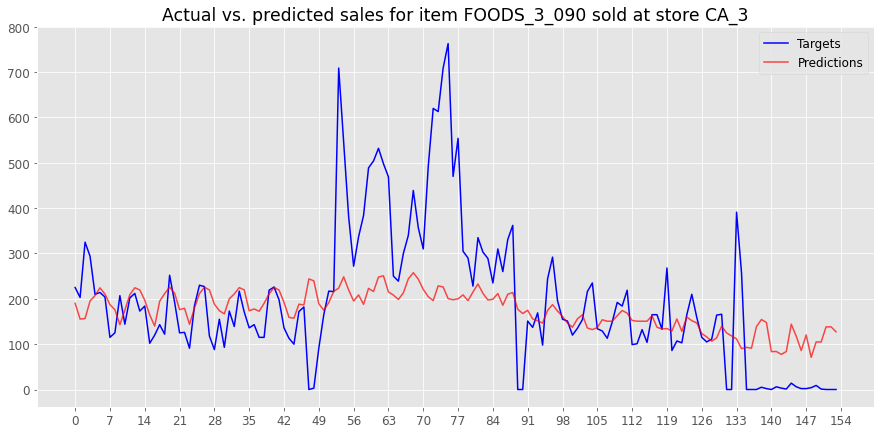

In [15]:
store_idx = 2
item_idx = 702
start = 500
length = 154
end = start + length

plt.figure(figsize=(15, 7))
g_trn = pd.concat([lgbm_trn['x'][['store_id', 'item_id']], lgbm_trn['y'],
                   pd.Series(lgbm_trn['yhat'].reshape(-1), 
                             name='preds', 
                             index=lgbm_trn['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])
idx = 1001
sample_ytrn = g_trn['sales'].apply(list).loc[(store_idx, item_idx)]
sample_ytrn_hat = g_trn['preds'].apply(list).loc[(store_idx, item_idx)]

plt.plot(sample_ytrn[start: end], 
         alpha=1, label='Targets', c='b')
plt.plot(sample_ytrn_hat[start: end], 
         alpha=0.7, label='Predictions', c='r')

plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, length + 1, 7))

plt.legend()
plt.show()

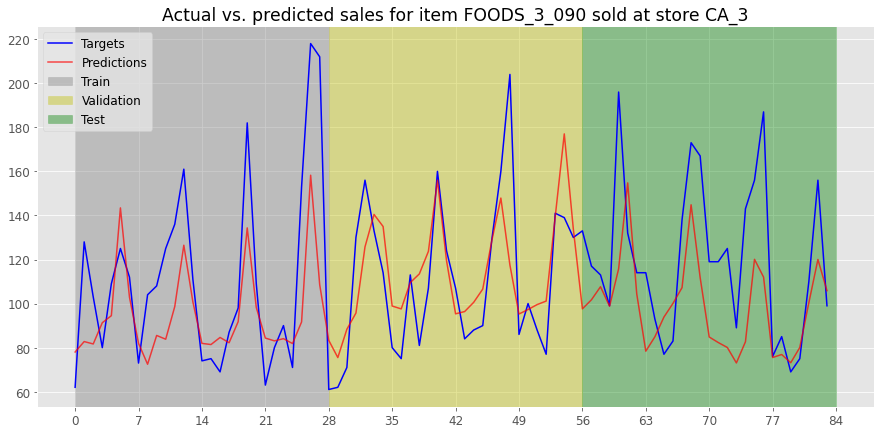

In [16]:
plt.figure(figsize=(15, 7))

g_val = pd.concat([lgbm_val['x'][['store_id', 'item_id']], lgbm_val['y'],
                   pd.Series(lgbm_val['yhat'].reshape(-1), 
                             name='preds', 
                             index=lgbm_val['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])
g_tst = pd.concat([lgbm_tst['x'][['store_id', 'item_id']], lgbm_tst['y'],
                   pd.Series(lgbm_tst['yhat'].reshape(-1), 
                             name='preds', 
                             index=lgbm_tst['y'].index)],
                  axis=1).groupby(['store_id', 'item_id'])

sample_yval = g_val['sales'].apply(list).loc[(store_idx, item_idx)]
sample_ytst = g_tst['sales'].apply(list).loc[(store_idx, item_idx)]
sample_yval_hat = g_val['preds'].apply(list).loc[(store_idx, item_idx)]
sample_ytst_hat = g_tst['preds'].apply(list).loc[(store_idx, item_idx)]

plt.plot(sample_ytrn[-28:] + sample_yval + sample_ytst, 
         alpha=1, label='Targets', c='b')
plt.plot(sample_ytrn_hat[-28:] + sample_yval_hat + sample_ytst_hat, 
         alpha=0.7, label='Predictions', c='r')


plt.axvspan(0, 28, color='grey', alpha=0.4, label='Train')
plt.axvspan(28, 28 + len(sample_yval), 
            color='y', alpha=0.4, label='Validation')
plt.axvspan(28 + len(sample_yval), 28 + len(sample_yval) + len(sample_ytst), 
            color='g', alpha=0.4, label='Test')

plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, 29 + len(sample_yval) + len(sample_ytst), 7))

plt.legend()
plt.show()

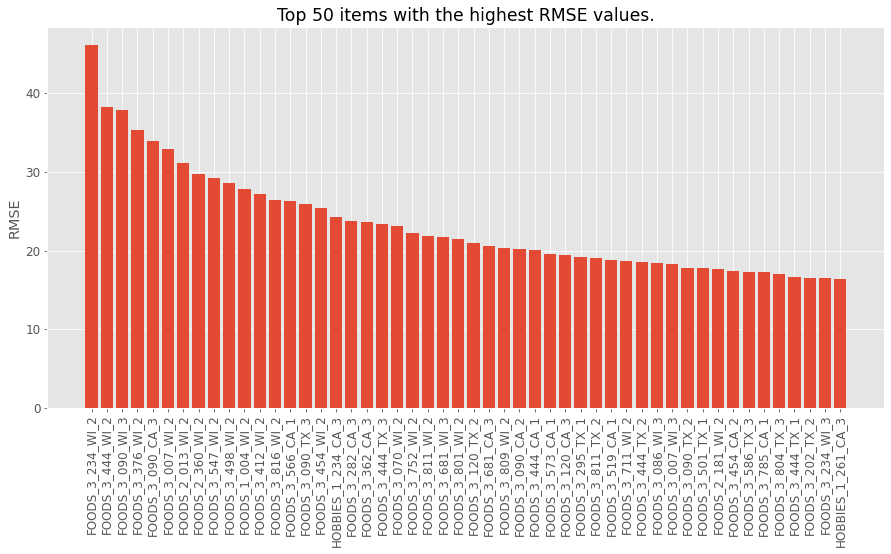

In [17]:
g_tst = pd.concat([lgbm_tst['x'][['store_id', 'item_id']], lgbm_tst['y'],
                   pd.Series(lgbm_tst['yhat'].reshape(-1), 
                             name='preds', 
                             index=lgbm_tst['y'].index)], 
                  axis=1).join(lgbm_data['id']).drop(columns=['store_id', 'item_id'])
g_tst = g_tst.groupby(['id'])
errors = g_tst.apply(lambda r: rmse(r['sales'], r['preds'])).sort_values(ascending=False)
top_50 = errors[:50]
items = [x[:-11] for x in top_50.index]

plt.figure(figsize=(15, 7))
plt.bar(items, top_50.values)
plt.xticks(rotation=90)
plt.title('Top 50 items with the highest RMSE values.')
plt.ylabel('RMSE')
plt.show()

### Hybrid

In [15]:
model_dir = proj_dir + 'models/hybrid/'

#### LSTM

In [16]:
# Whether to retrain the model or load a previously saved model.
retrain_hyb_lstm = 0
cp_dir = model_dir + 'lstm_best.h5'
log_dir = model_dir + 'lstm_log.csv'
opt_dir = proj_dir + 'models/lstm/lstm_optimizer.json'

##### Model Input

In [17]:
errors, params = [], []
with open(opt_dir, 'r') as f:
    opt_hist = f.readlines()
for line in opt_hist:
    hist = json.loads(line)
    errors.append(hist['target'])
    params.append(hist['params'])
best_iter = np.argmax(errors)
best_lstm_params = params[best_iter].copy()
print('Best Hyperparameters:', json.dumps(best_lstm_params, indent=1))
best_lstm_steps = int(best_lstm_params.pop('steps'))
best_lstm_batch_size = int(best_lstm_params.pop('batch_size'))

Best Hyperparameters: {
 "batch_size": 59.55450782680462,
 "dropout_rate": 0.22584804540539424,
 "last_units": 405.8013201601185,
 "learning_rate": 0.0005337931666217087,
 "lr_decay": 0.0004451312984142303,
 "n_layers": 3.821599889355496,
 "norm": 0.293455955740044,
 "steps": 23.247426563787744,
 "units_decay": 0.7520324757727471
}


In [18]:
start_day = 300
hyb_lstm_scaler = MinMaxScaler(feature_range=(0, 1))
hyb_lstm_trn, hyb_lstm_val, hyb_lstm_tst = lstm_dataprep(data=sales,
                                                         start_day=start_day, 
                                                         val_days=28, 
                                                         tst_days=28, 
                                                         steps=best_lstm_steps,
                                                         scaler=hyb_lstm_scaler,
                                                         save=False,
                                                         add_features=False,
                                                         verbose=1).values() 

print('\nTraining:', hyb_lstm_trn['x'].shape, hyb_lstm_trn['y'].shape)
print('Validation:', hyb_lstm_val['x'].shape, hyb_lstm_val['y'].shape)
print('Test:', hyb_lstm_tst['x'].shape, hyb_lstm_tst['y'].shape)

Added features: []
Separating training, validation, and test sets...
Scaling the data...
Generating time series data...




Training: (1562, 23, 30490) (1562, 30490)
Validation: (28, 23, 30490) (28, 30490)
Test: (28, 23, 30490) (28, 30490)


In [19]:
hyb_lstm_trn['y_orig'] = hyb_lstm_scaler.inverse_transform(hyb_lstm_trn['y'])
hyb_lstm_val['y_orig'] = hyb_lstm_scaler.inverse_transform(hyb_lstm_val['y'])
hyb_lstm_tst['y_orig'] = hyb_lstm_scaler.inverse_transform(hyb_lstm_tst['y'])

##### Model Creation

In [20]:
def create_lstm(in_shape,
                out_shape,
                n_layers=1,
                last_units=64,
                units_decay=1,
                hidden_sizes=None,
                learning_rate=0.001, 
                lr_decay=0.0,
                dropout_rate=0.1,
                norm=True):
    """
    Creates an LSTM model.
    
    :param in_shape: The shape of the input data.
    :param out_shape: The shape of the model output.
    :param n_layers: The number of hidden LSTM layers.
    :param last_units: The number of units for the last hidden LSTM layer.
    :param units_decay: The decay rate of the number of units going from last hidden layer to the first.
    :param hidden_sizes: A list containing the number of nodes for each hidden LSTM layer. This is meant to be used as 
        an alternative to n_layers, n_units, and units_scale to specify the number of hidden layers and the number of 
        nodes per hidden layer.
    :param learning_rate: The learning rate of the model.
    :param lr_decay: The learning rate decay of the model.
    :param dropout_rate: The dropout rate for the dropout layers.
    :param norm: Whether to use a batch normalization layer after each LSTM layer or not.
    
    :return An LSTM model.
    """
    kb.clear_session()
    tf.compat.v1.reset_default_graph()
    keras.backend.clear_session()

    n_layers = int(n_layers)
    last_units = int(last_units)
    norm = round(norm)
    model = Sequential()

    if hidden_sizes is not None:
        for i_layer, i_units in enumerate(hidden_sizes):
            return_sequences = False if i_layer+1 == len(hidden_sizes) else True
            if i_layer == 0:  # Specify the input shape for the first layer.
                model.add(LSTM(units=int(i_units), 
                               return_sequences=return_sequences,
                               input_shape=in_shape))
            else:
                model.add(LSTM(units=int(i_units), 
                               return_sequences=return_sequences))  
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate))
    else:
        for i_layer in range(n_layers):
            return_sequences = False if i_layer+1 == n_layers else True
            if i_layer == 0:  # Specify the input shape for the first layer.
                model.add(LSTM(units=max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                               return_sequences=return_sequences,
                               input_shape=in_shape))
            else:
                model.add(LSTM(units=max(1, int(last_units*(units_decay**(n_layers-i_layer-1)))), 
                               return_sequences=return_sequences))    
            if norm:
                model.add(BatchNormalization())
            if dropout_rate:
                model.add(Dropout(dropout_rate))

    # Adding the output layer.
    model.add(Dense(units=out_shape))

    model.compile(optimizer=optimizers.Adam(lr=learning_rate, decay=lr_decay), 
                  loss=rmse_tf)
    
    return model

##### Model Training

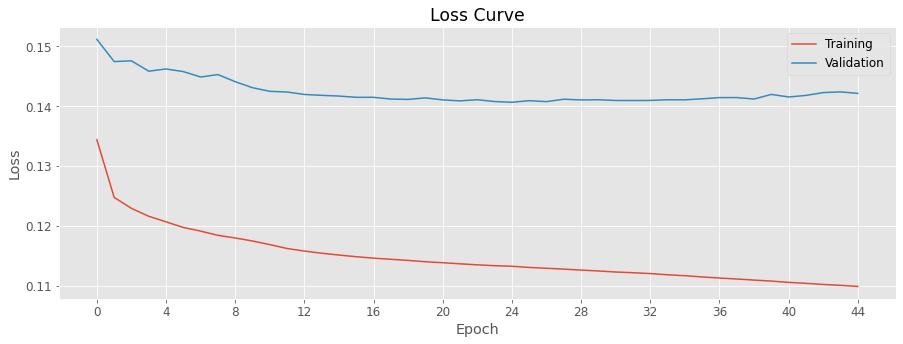

In [21]:
if retrain_hyb_lstm:
    # Create the model
    hyb_lstm_model = create_lstm(hyb_lstm_trn['x'].shape[1:], 
                                 hyb_lstm_trn['y'].shape[1],
                                 **best_lstm_params)  
    hyb_lstm_model.summary()  

    # Defining some callbacks.
    save = True
    graph = True
    early_stopping = True
    callback_log = CSVLogger(log_dir, separator=',') 
    callbacks = [callback_log]
    if save:
        callback_cp = ModelCheckpoint(cp_dir, save_best_only=True, period=1,
                                      monitor='val_loss', mode='min')
        callbacks.append(callback_cp)
    if graph:
        max_idx = np.unravel_index(hyb_lstm_trn['y_orig'].argmax(), 
                                   hyb_lstm_trn['y_orig'].shape)
        callback_pp = PredictionsPlot(hyb_lstm_model, hyb_lstm_trn['x'], hyb_lstm_trn['y'], 
                                      length=154, idx=max_idx, period=5)
        callbacks.append(callback_pp)
    if early_stopping:
        callback_es = EarlyStopping(monitor='val_loss', patience=20, 
                                    mode='min', verbose=1)
        callbacks.append(callback_es)

    # Fitting the LSTM to the training set.
    hyb_lstm_model.fit(hyb_lstm_trn['x'], hyb_lstm_trn['y'],
                       epochs=1000,
                       batch_size=best_lstm_batch_size,
                       validation_data=(hyb_lstm_val['x'], hyb_lstm_val['y']),
                       callbacks=callbacks,
                       shuffle=True)

hyb_lstm_model = load_model(cp_dir, custom_objects={'rmse_tf': rmse_tf})    
hyb_lstm_log = pd.read_csv(log_dir, delimiter=',')
plot_loss(hyb_lstm_log['loss'], hyb_lstm_log['val_loss'])

##### Model Output

In [22]:
hyb_lstm_trn['yhat'] = hyb_lstm_model.predict(hyb_lstm_trn['x'], batch_size=28)
hyb_lstm_val['yhat'] = hyb_lstm_model.predict(hyb_lstm_val['x'], batch_size=28)
hyb_lstm_tst['yhat'] = hyb_lstm_model.predict(hyb_lstm_tst['x'], batch_size=28)

In [23]:
del hyb_lstm_trn['x'], hyb_lstm_val['x'], hyb_lstm_tst['x']
del hyb_lstm_trn['trn'], hyb_lstm_val['val']
gc.collect()

3109

#### LightGBM

In [24]:
# Whether to retrain the model or load a previously saved model.
retrain_hyb_lgbm = 0
cp_dir = model_dir + 'lgbm_best.txt'
log_dir = model_dir + 'lgbm_log.csv'
opt_dir = proj_dir + 'models/lgbm/lgbm_optimizer.json'

##### Model Input

In [25]:
all_days = list(sales.columns[(-hyb_lstm_tst['y'].shape[0] -
                               hyb_lstm_val['y'].shape[0] -
                               hyb_lstm_trn['y'].shape[0]): ])
hyb_lstm_error = np.vstack([hyb_lstm_trn['y'] - hyb_lstm_trn['yhat'], 
                            hyb_lstm_val['y'] - hyb_lstm_val['yhat'],
                            hyb_lstm_tst['y'] - hyb_lstm_tst['yhat']]).T
hyb_lstm_error = pd.DataFrame(hyb_lstm_error,
                              index=sales['id'],
                              columns=all_days)

hyb_lgbm_data = sales.iloc[:, :6].set_index('id').join(hyb_lstm_error).reset_index()

In [26]:
hyb_lgbm_input = row_wise_dataprep(data=hyb_lgbm_data, 
                                   start_day=0)
hyb_lgbm_trn, hyb_lgbm_val, hyb_lgbm_tst = \
    row_wise_train_test_split(hyb_lgbm_input,
                              val_days=28,
                              tst_days=28).values()

hyb_lgbm_datasets = prepare_lgbm_training_datasets(hyb_lgbm_trn, hyb_lgbm_val)

Merging datasets...
Adding calendar data...
Encoding the categorical features...



Reducing memory usage - Current Memory usage is 4647.09MB...



Memory usage after optimization is: 1482.26MB
Decreased by 68.1%
Separating train, validation, and test sets...


##### Model Training

In [27]:
errors, params = [], []
with open(opt_dir, 'r') as f:
    opt_hist = f.readlines()
for line in opt_hist:
    hist = json.loads(line)
    errors.append(hist['target'])
    params.append(hist['params'])
best_iter = np.argmax(errors)
best_lgbm_params = params[best_iter].copy()
best_lgbm_params['num_leaves'] = int(best_lgbm_params['num_leaves'])
best_lgbm_params['min_data_in_leaf'] = int(best_lgbm_params['min_data_in_leaf'])
print('Best Hyperparameters:', json.dumps(best_lgbm_params, indent=1))

Best Hyperparameters: {
 "feature_fraction": 0.553332400822897,
 "lambda_l2": 0.21955370052423398,
 "learning_rate": 0.09789220144755495,
 "min_data_in_leaf": 749,
 "num_leaves": 1534
}


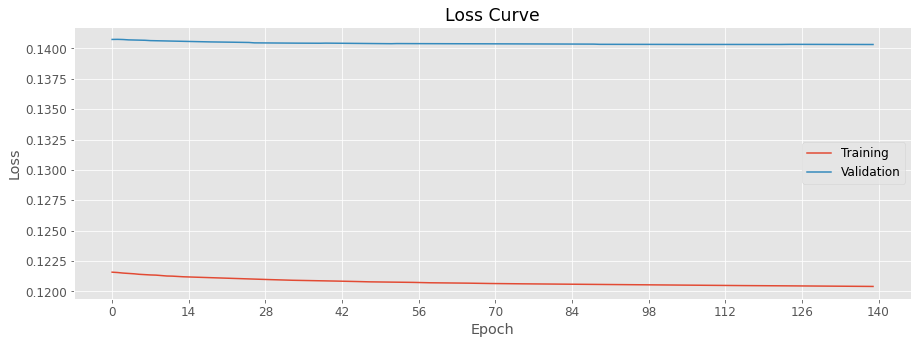

In [29]:
if retrain_hyb_lgbm:
    fixed_params = {
        'objective' : 'regression',
        'boosting': 'gbdt',
        'metric' : 'rmse',
        'num_iterations' : 1000,
        'force_row_wise' : True,
        'num_threads' : 6
    }
    best_lgbm_params.update(fixed_params)
    hyb_lgbm_log = {}
    hyb_lgbm_model = lgb.train(best_lgbm_params, 
                               hyb_lgbm_datasets['trn'], 
                               valid_sets=[hyb_lgbm_datasets['trn'],
                                           hyb_lgbm_datasets['val']], 
                               verbose_eval=5,
                               callbacks=[lgb.record_evaluation(hyb_lgbm_log),
                                          lgb.early_stopping(20)])

    model_best_epoch = np.argmin(hyb_lgbm_log['valid_1']['rmse'])
    hyb_lgbm_model.save_model(cp_dir, num_iteration=model_best_epoch)
    with open(log_dir, 'wb') as f:
        pickle.dump(hyb_lgbm_log, f)

hyb_lgbm_model = lgb.Booster(model_file=cp_dir)
with open(log_dir, 'rb') as f:
    hyb_lgbm_log = pickle.load(f)

plot_loss(hyb_lgbm_log['training']['rmse'], hyb_lgbm_log['valid_1']['rmse'])

##### Model Output

In [30]:
hyb_lgbm_trn['yhat'] = hyb_lgbm_model.predict(hyb_lgbm_trn['x'], num_thread=6)
hyb_lgbm_val['yhat'] = hyb_lgbm_model.predict(hyb_lgbm_val['x'], num_thread=6)
hyb_lgbm_tst['yhat'] = hyb_lgbm_model.predict(hyb_lgbm_tst['x'], num_thread=6)

In [31]:
# Unmelting LGBM predictions so we can aggregate them with LSTM predictions.
hyb_lgbm_trn['yhat_unmelted'] = pd.concat([hyb_lgbm_trn['x'][['store_id', 'item_id', 'd']],
                                           pd.Series(hyb_lgbm_trn['yhat'].reshape(-1),
                                                     name='preds', 
                                                     index=hyb_lgbm_trn['y'].index)], axis=1)
hyb_lgbm_trn['yhat_unmelted'] = hyb_lgbm_trn['yhat_unmelted'].pivot_table(index=['store_id', 'item_id'], 
                                                                          columns='d')
hyb_lgbm_trn['yhat_unmelted'] = hyb_lgbm_trn['yhat_unmelted']['preds'].reset_index()
hyb_lgbm_trn['yhat_unmelted'].columns.name = None
hyb_lgbm_trn['yhat_unmelted'].fillna(0, inplace=True)
hyb_lgbm_trn['yhat_unmelted'] = hyb_lgbm_trn['yhat_unmelted'].drop(columns=['store_id', 'item_id']).values.T

hyb_lgbm_val['yhat_unmelted'] = pd.concat([hyb_lgbm_val['x'][['store_id', 'item_id', 'd']],
                                           pd.Series(hyb_lgbm_val['yhat'].reshape(-1),
                                                     name='preds', 
                                                     index=hyb_lgbm_val['y'].index)], axis=1)
hyb_lgbm_val['yhat_unmelted'] = hyb_lgbm_val['yhat_unmelted'].pivot_table(index=['store_id', 'item_id'], 
                                                                          columns='d')
hyb_lgbm_val['yhat_unmelted'] = hyb_lgbm_val['yhat_unmelted']['preds'].reset_index()
hyb_lgbm_val['yhat_unmelted'].columns.name = None
hyb_lgbm_val['yhat_unmelted'].fillna(0, inplace=True)
hyb_lgbm_val['yhat_unmelted'] = hyb_lgbm_val['yhat_unmelted'].drop(columns=['store_id', 'item_id']).values.T

hyb_lgbm_tst['yhat_unmelted'] = pd.concat([hyb_lgbm_tst['x'][['store_id', 'item_id', 'd']],
                                           pd.Series(hyb_lgbm_tst['yhat'].reshape(-1),
                                                     name='preds', 
                                                     index=hyb_lgbm_tst['y'].index)], axis=1)
hyb_lgbm_tst['yhat_unmelted'] = hyb_lgbm_tst['yhat_unmelted'].pivot_table(index=['store_id', 'item_id'], 
                                                                          columns='d')
hyb_lgbm_tst['yhat_unmelted'] = hyb_lgbm_tst['yhat_unmelted']['preds'].reset_index()
hyb_lgbm_tst['yhat_unmelted'].columns.name = None
hyb_lgbm_tst['yhat_unmelted'].fillna(0, inplace=True)
hyb_lgbm_tst['yhat_unmelted'] = hyb_lgbm_tst['yhat_unmelted'].drop(columns=['store_id', 'item_id']).values.T

#### Results

In [32]:
hyb_trn, hyb_val, hyb_tst = {}, {}, {}

hyb_trn['yhat'] = hyb_lstm_trn['yhat'] + hyb_lgbm_trn['yhat_unmelted']
hyb_val['yhat'] = hyb_lstm_val['yhat'] + hyb_lgbm_val['yhat_unmelted']
hyb_tst['yhat'] = hyb_lstm_tst['yhat'] + hyb_lgbm_tst['yhat_unmelted']

hyb_trn['yhat_orig'] = hyb_lstm_scaler.inverse_transform(hyb_trn['yhat'])
hyb_val['yhat_orig'] = hyb_lstm_scaler.inverse_transform(hyb_val['yhat'])
hyb_tst['yhat_orig'] = hyb_lstm_scaler.inverse_transform(hyb_tst['yhat'])

In [33]:
# Predicting 28 days ahead for the test set.
hyb_lstm_tst28 = hyb_lstm_tst['tst'].copy()
hyb_lstm_tst28[-28:, :] = np.nan
tst_days = hyb_lgbm_tst['x']['d'].unique()
n_days = len(tst_days)

for d in range(n_days):
    lstm_xtst = hyb_lstm_tst28[d: d + best_lstm_steps]
    lstm_pred = hyb_lstm_model.predict(np.expand_dims(lstm_xtst, axis=0))
    lgbm_pred = hyb_lgbm_tst['yhat'][hyb_lgbm_tst['x']['d'] == tst_days[d]]
    final_pred = lstm_pred + lgbm_pred
    hyb_lstm_tst28[d + best_lstm_steps, :] = final_pred

hyb_tst['yhat28_orig'] = hyb_lstm_scaler.inverse_transform(hyb_lstm_tst28[-n_days:, :])

In [34]:
# ME...
print('Train ME: %f' % mean_error(hyb_lstm_trn['y_orig'], hyb_trn['yhat_orig']))
print('Validation ME: %f' % mean_error(hyb_lstm_val['y_orig'], hyb_val['yhat_orig']))
print('Test ME: %f' % mean_error(hyb_lstm_tst['y_orig'], hyb_tst['yhat_orig']))
print('Test ME: (28 days ahead) %f' % mean_error(hyb_lstm_tst['y_orig'], hyb_tst['yhat28_orig']))

Train ME: 0.014171
Validation ME: -0.042652
Test ME: -0.140206
Test ME: (28 days ahead) -0.119162


In [35]:
# RMSE...
print('Train RMSE: %f' % rmse(hyb_lstm_trn['y_orig'], hyb_trn['yhat_orig']))
print('Validation RMSE: %f' % rmse(hyb_lstm_val['y_orig'], hyb_val['yhat_orig']))
print('Test RMSE: %f' % rmse(hyb_lstm_tst['y_orig'], hyb_tst['yhat_orig']))
print('Test RMSE (28 days ahead) %f' % rmse(hyb_lstm_tst['y_orig'], hyb_tst['yhat28_orig']))

Train RMSE: 2.101552
Validation RMSE: 2.117059
Test RMSE: 2.262681
Test RMSE (28 days ahead) 2.256981


In [36]:
# RMSSE...
print('Train RMSSE: %f' % rmsse(hyb_lstm_trn['y_orig'], hyb_trn['yhat_orig']))
print('Validation RMSSE: %f' % rmsse(hyb_lstm_val['y_orig'], hyb_val['yhat_orig']))
print('Test RMSSE: %f' % rmsse(hyb_lstm_tst['y_orig'], hyb_tst['yhat_orig']))
naive_preds28 = hyb_lstm_val['y_orig']
print('Test RMSSE (28 days ahead) %f' % rmsse(hyb_lstm_tst['y_orig'], hyb_tst['yhat28_orig'],
                                              hyb_lstm_tst['y_orig'], naive_preds28))

Train RMSSE: 0.781331
Validation RMSSE: 0.824537
Test RMSSE: 0.861918
Test RMSSE (28 days ahead) 0.797754


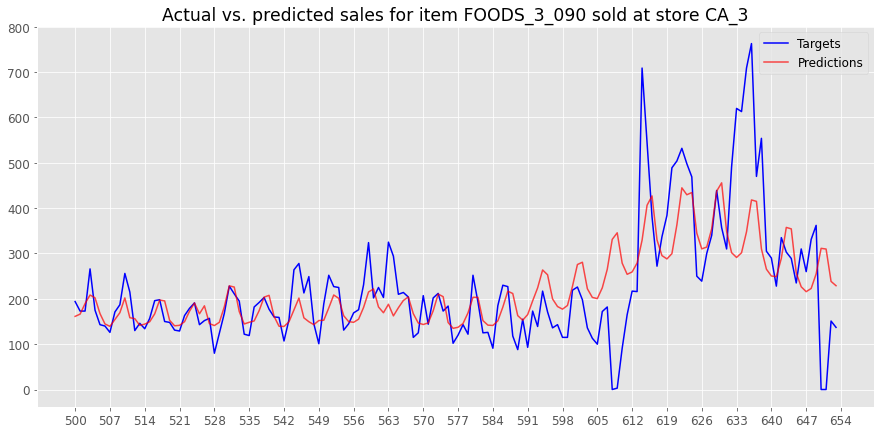

In [37]:
item_idx = 'FOODS_3_090_CA_3_evaluation'
ids = sales['id'].values
idx = np.where(ids == item_idx)[0][0]
start = 500
length = 154
end = start + length

plt.figure(figsize=(15, 7))
plt.plot(hyb_lstm_trn['y_orig'][start:end, idx], 
         alpha=1, label='Targets', c='b')
plt.plot(hyb_trn['yhat_orig'][start:end, idx], 
         alpha=0.7, label='Predictions', c='r')
plt.xticks(ticks=np.arange(0, length+1, 7), labels=np.arange(start, end+1, 7))
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')

plt.legend()
plt.show()

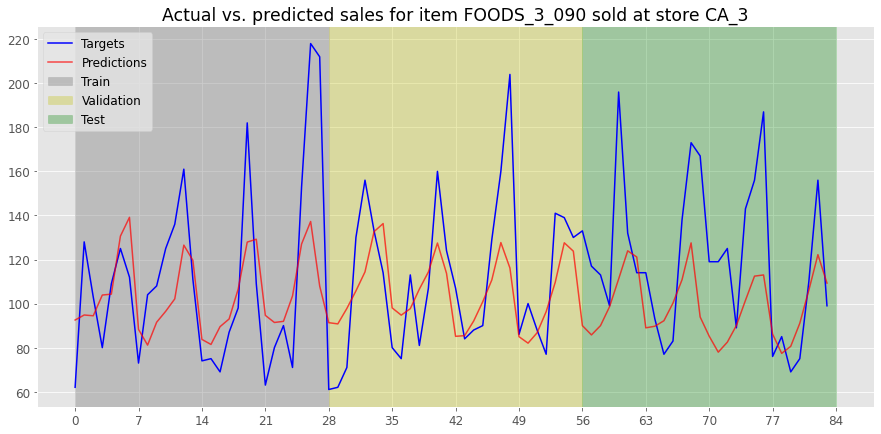

In [38]:
plt.figure(figsize=(15, 7))
plt.plot(np.append(hyb_lstm_trn['y_orig'][-28:, idx], 
                   [hyb_lstm_val['y_orig'][:, idx], 
                    hyb_lstm_tst['y_orig'][:, idx]]), 
         alpha=1, label='Targets', c='b')
plt.plot(np.append(hyb_trn['yhat_orig'][-28:, idx], 
                   [hyb_val['yhat_orig'][:, idx], 
                    hyb_tst['yhat_orig'][:, idx]]), 
         alpha=0.7, label='Predictions', c='r')
plt.axvspan(0, 28, color='grey', alpha=0.4, label='Train')
plt.axvspan(28, 28 + len(hyb_lstm_val['y']), color='y', alpha=0.3, label='Validation')
plt.axvspan(28 + len(hyb_lstm_val['y']), 28 + len(hyb_lstm_val['y']) + len(hyb_lstm_tst['y']), 
            color='g', alpha=0.3, label='Test')
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3')
plt.xticks(ticks=np.arange(0, len(hyb_lstm_val['y']) + len(hyb_lstm_tst['y']) + 29, 7))

plt.legend()
plt.show()

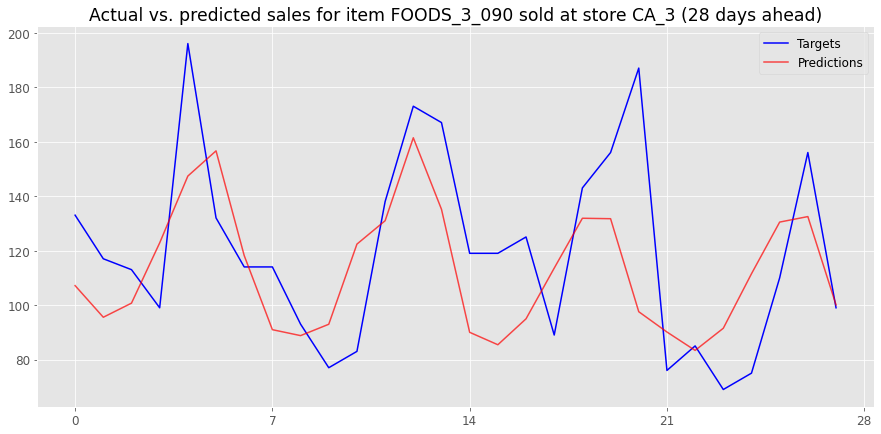

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(hyb_lstm_tst['y_orig'][:, idx], 
         alpha=1, label='Targets', c='b')
plt.plot(hyb_tst['yhat28_orig'][:, idx], 
         alpha=0.7, label='Predictions', c='r')
plt.title('Actual vs. predicted sales for item FOODS_3_090 sold at store CA_3 (28 days ahead)')
plt.xticks(ticks=np.arange(0, len(hyb_lstm_tst['y']) + 1, 7))

plt.legend()
plt.show()

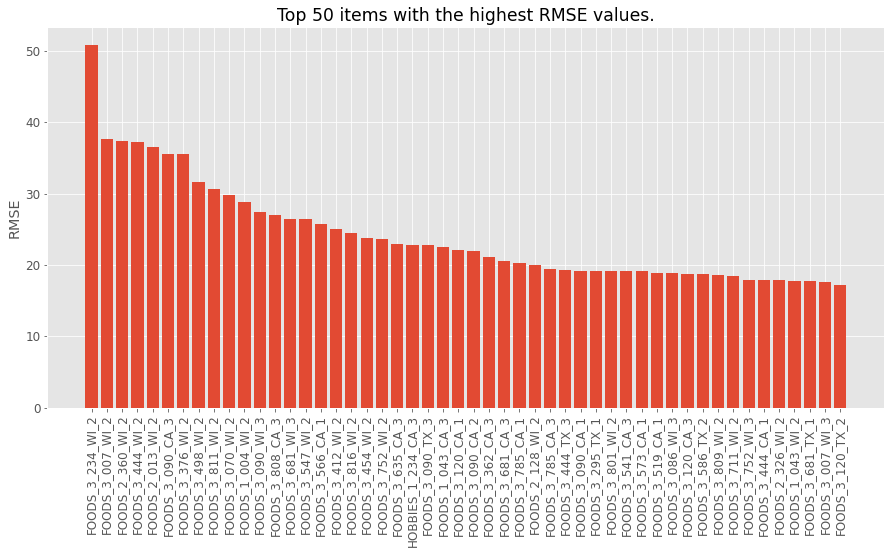

In [40]:
items = [x[:-11] for x in sales['id'].values]
rmse_cols = []
for col in tqdm(range(hyb_lstm_tst['y_orig'].shape[1])):
    rmse_cols.append(rmse(hyb_lstm_tst['y_orig'][:, col], 
                          hyb_tst['yhat_orig'][:, col]))
rmse_cols = pd.DataFrame(rmse_cols, index=items)
rmse_cols = rmse_cols.sort_values(by=0, ascending=False)
top_50 = rmse_cols.iloc[:50]

plt.figure(figsize=(15, 7))
plt.bar(top_50.index, top_50[0])
plt.xticks(rotation=90)
plt.title('Top 50 items with the highest RMSE values.')
plt.ylabel('RMSE')
plt.show()